# Data collection from the input file

This code is used to analyse the geometries after xtb_dock - crest.
The code works with file `crest_ensemble.xyz` and should:
1. Extract geometry values (alpha, beta, distance, energy)
2. Add to the pandas dataframe along with the name of the folder
3. Add the corresponding `structure_x` code

In [1]:
import pandas as pd
import numpy as np
import os, re

Get the atom numbers from the Avogadro

In [2]:
# global variables
loc_s = 160
loc_cs = 165
loc_n = 1
loc_cn = 9

In [3]:
df = pd.read_csv('crest_ensemble.xyz')

In [4]:
#reading number of atoms

for col in df.columns:
    atoms = int(col)
    
n_rows = atoms + 2

#Creating dataframes of separate atoms

df_s = df[df.index % n_rows == loc_s] # for S
df_cs = df[df.index % n_rows == loc_cs] # for C4 in sulfonate
df_n = df[df.index % n_rows == loc_n] # for N
df_cn = df[df.index % n_rows == loc_cn] # for C4 in pyridinium

#Formatting strings, splitting into columns, delete the element column, setting type to float

df_s= df_s[df_s.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_s = df_s.drop(columns=[0, 1]).astype('float64')

df_cs= df_cs[df_cs.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cs = df_cs.drop(columns=[0, 1]).astype('float64')


df_n= df_n[df_n.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_n = df_n.drop(columns=[0, 1]).astype('float64')


df_cn= df_cn[df_cn.columns[0]].str.replace(' +', ' ', regex=True).str.split(' ', expand=True)
df_cn = df_cn.drop(columns=[0, 1]).astype('float64')

# xTB gfn2 energy values

df_e = df[df.index % n_rows == 0].astype('float64')

In [5]:
# Creating numpy arrays

arr_s = np.array(df_s)
arr_cs = np.array(df_cs)
arr_n = np.array(df_n)
arr_cn = np.array(df_cn)
arr_e = np.array(df_e)

In [6]:
# functions to calculate angle

def vectors(arr1, arr2):
    arr3 = arr2 - arr1
    return arr3

def vector_len(arr):
    v_len = np.sqrt((arr[:,0])**2 + (arr[:,1])**2 + (arr[:,2])**2)
    return v_len

def dot_product(arr1, arr2):
    dot_pr = arr1[:,0]*arr2[:,0] + arr1[:,1]*arr2[:,1] + arr1[:,2]*arr2[:,2]
    return dot_pr

def angle(arr1, arr2):
    cos_a = (dot_product(arr1, arr2))/(vector_len(arr1)*vector_len(arr2))
    result = np.degrees(np.arccos(cos_a))
    return result

In [7]:
# alpha angle
#vector N - C(N)
vector_N_Cn = vectors(arr_n, arr_cn)
     
#vector N - C(S)
vector_N_Cs = vectors(arr_n, arr_cs)
        
alpha_ang = np.around(angle(vector_N_Cn, vector_N_Cs), decimals=1)

# beta angle

vector_S_Cn = vectors(arr_s, arr_cn)
        
#vector S - C(S)
vector_S_Cs = vectors(arr_s, arr_cs)
        
beta_ang = np.around(angle(vector_S_Cs, vector_S_Cn), decimals=1)

# distance
ns_dist = np.around(vector_len(vectors(arr_n, arr_s)), decimals=1)

# combine into dataframe

stacked = np.column_stack((alpha_ang, beta_ang, ns_dist, arr_e)) # need this because numpy nicely transforms everything

inputs = pd.DataFrame(data=stacked, columns=['alpha_inp', 'beta_inp', 'distance_inp', 'energy_inp'])

inputs['rel_energy_inp_kcal'] = (inputs['energy_inp'] - inputs['energy_inp'].min())*627.509

In [8]:
# label each structure according to how the inputs were created
names = []
for _ in range(1, inputs.shape[0]+1):
    names.append(f'structure_{_}')
inputs['name'] = names

In [9]:
inputs

,alpha_inp,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,name
0,166.7,174.1,4.5,-352.587492,0.000000,structure_1
1,176.4,177.5,4.4,-352.587031,0.289407,structure_2
2,176.0,177.0,4.4,-352.586989,0.315574,structure_3
3,171.0,172.9,4.4,-352.586338,0.724164,structure_4
4,173.0,175.5,4.5,-352.585808,1.056800,structure_5
...,...,...,...,...,...,...
86,47.5,131.2,7.8,-352.565335,13.903792,structure_87
87,104.2,166.4,8.4,-352.565164,14.011040,structure_88
88,102.1,165.9,8.4,-352.565023,14.099550,structure_89
89,144.1,156.1,7.0,-352.564311,14.546292,structure_90


# Analysis of the geometric parameters

First let's look at the distributions of angles and distances

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

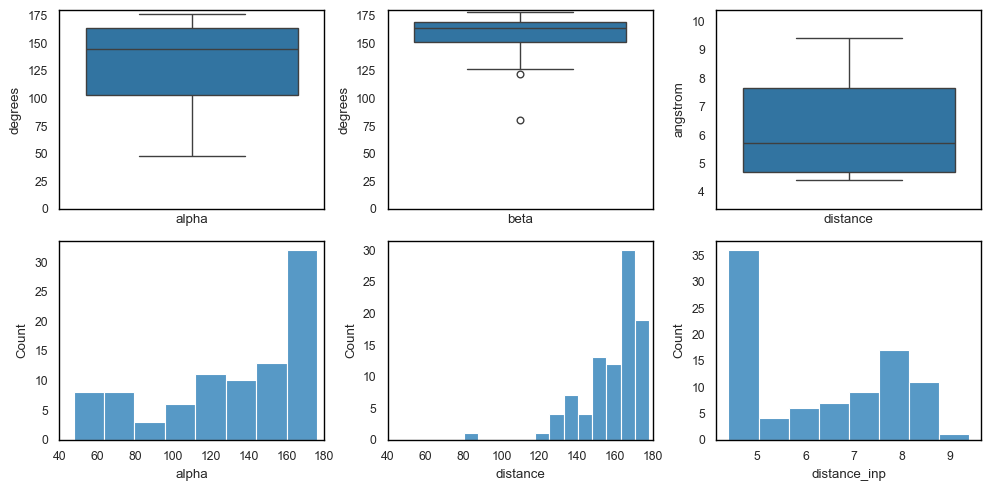

In [11]:
sns.set_context("paper")
sns.set_style("white", {"axes.edgecolor": "black"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axs = axs.flatten()

sns.boxplot(inputs['alpha_inp'], ax=axs[0])
ax=axs[0]
ax.set_ylabel('degrees')
ax.set_xlabel('alpha')
ax.set_ylim([0,180])
ax.set_xticks([])

sns.boxplot(inputs['beta_inp'], ax=axs[1])
ax=axs[1]
ax.set_ylabel('degrees')
ax.set_ylim([0,180])
ax.set_xlabel('beta')
ax.set_xticks([])

sns.boxplot(inputs['distance_inp'], ax=axs[2])
ax=axs[2]
ax.set_ylabel('angstrom')
ax.set_ylim([inputs['distance_inp'].min()-1, inputs['distance_inp'].max()+1])
ax.set_xlabel('distance')
ax.set_xticks([])

sns.histplot(inputs['alpha_inp'], ax=axs[3])
ax=axs[3]
ax.set_xlim([40,180])
ax.set_xlabel('alpha')

sns.histplot(inputs['beta_inp'], ax=axs[4])
ax=axs[4]
ax.set_xlim([40,180])
ax.set_xlabel('beta')

sns.histplot(inputs['distance_inp'], ax=axs[5])
ax.set_xlabel('distance')
plt.tight_layout()
plt.show()

Let's look at the angles more closely.

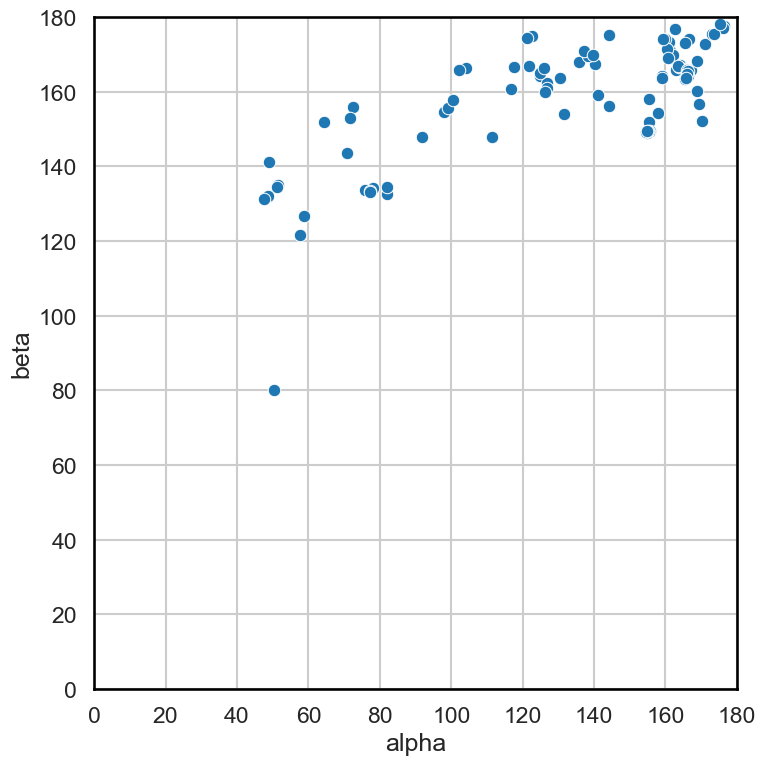

In [12]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})

fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

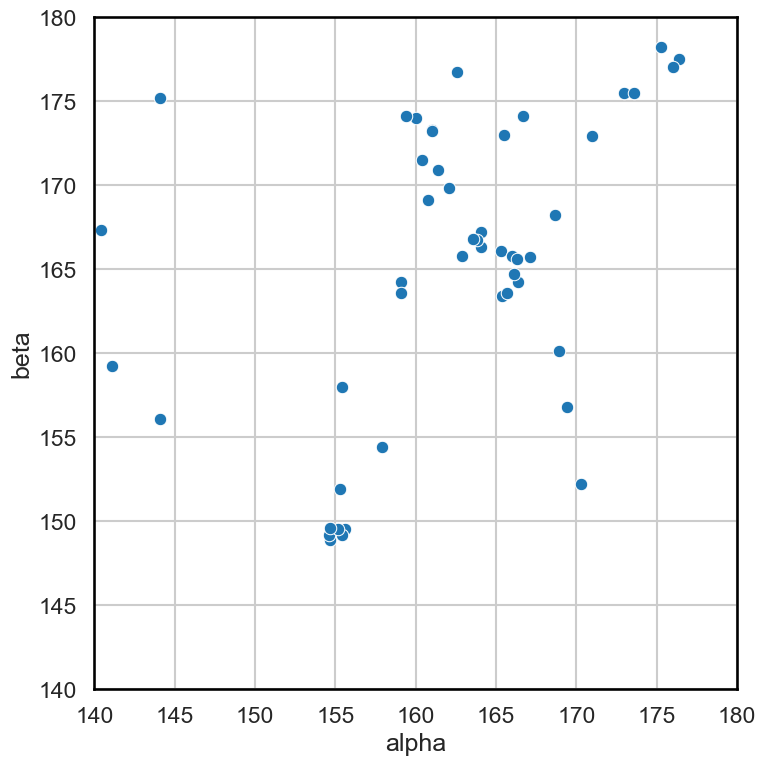

In [13]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

Now with energy:

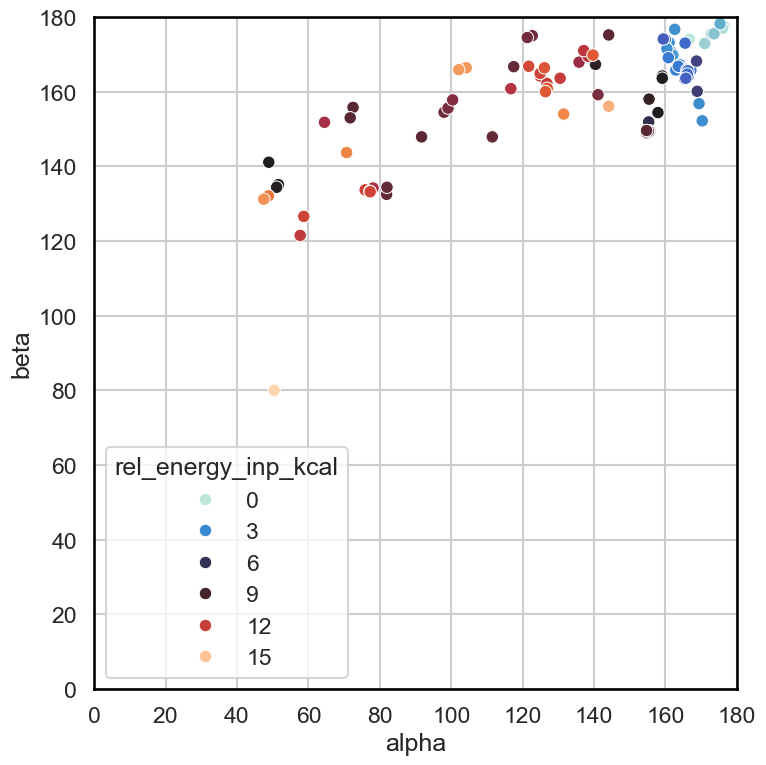

In [14]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='rel_energy_inp_kcal', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

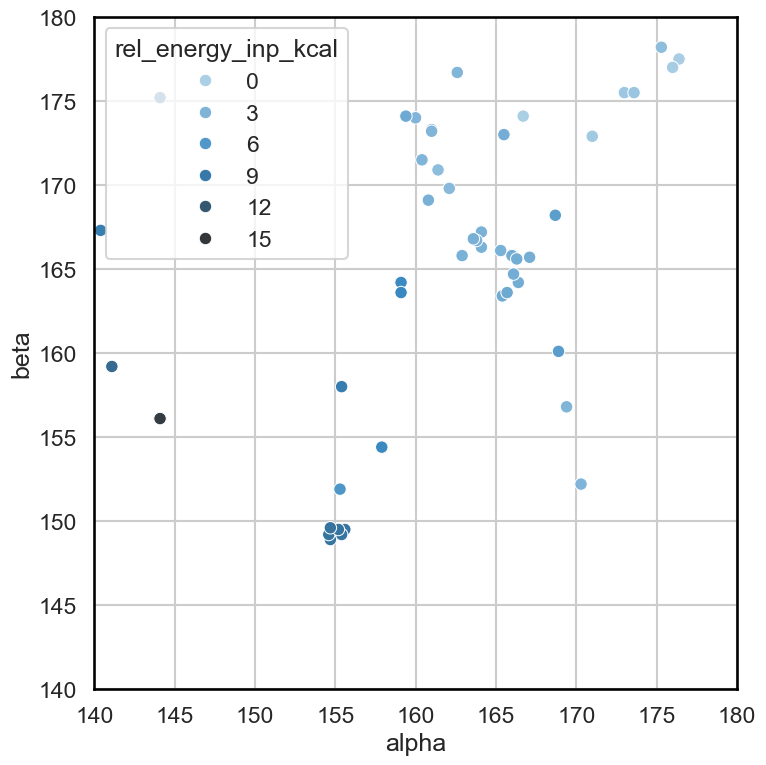

In [15]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='rel_energy_inp_kcal', palette='Blues_d')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

# Clustering

Clustering will be performed using KMeans from scikit-learn (because it's simple).

In [16]:
import warnings
from sklearn.cluster import KMeans

First we find the best number of clusters from the elbow rule, using only alpha and beta angles.

In [17]:
warnings.filterwarnings('ignore')
inertias = []
for i in range(1,11): # more than 10 clusters make no sense for 93 samples
    model = KMeans(n_clusters=i, random_state=123, max_iter=1000)
    model.fit(inputs[['alpha_inp', 'beta_inp']])
    inertias.append(model.inertia_)

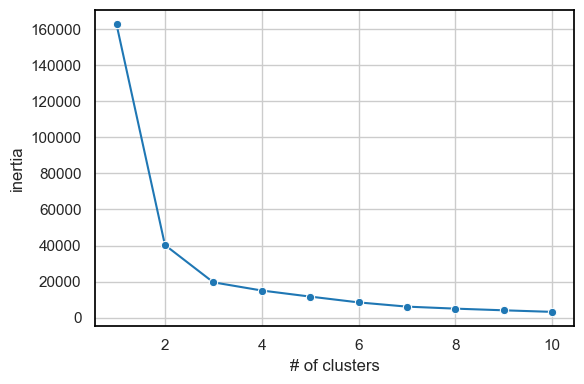

In [18]:
sns.set_context("notebook")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=range(1,11), y=inertias, markers=True, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.tight_layout()
plt.show()

4 clusters look like a reasonable solution here, let's viasualize them

In [19]:
model = KMeans(n_clusters=4, random_state=123, max_iter=1000)
model.fit(inputs[['alpha_inp', 'beta_inp']])
inputs['cluster_inp'] = model.labels_

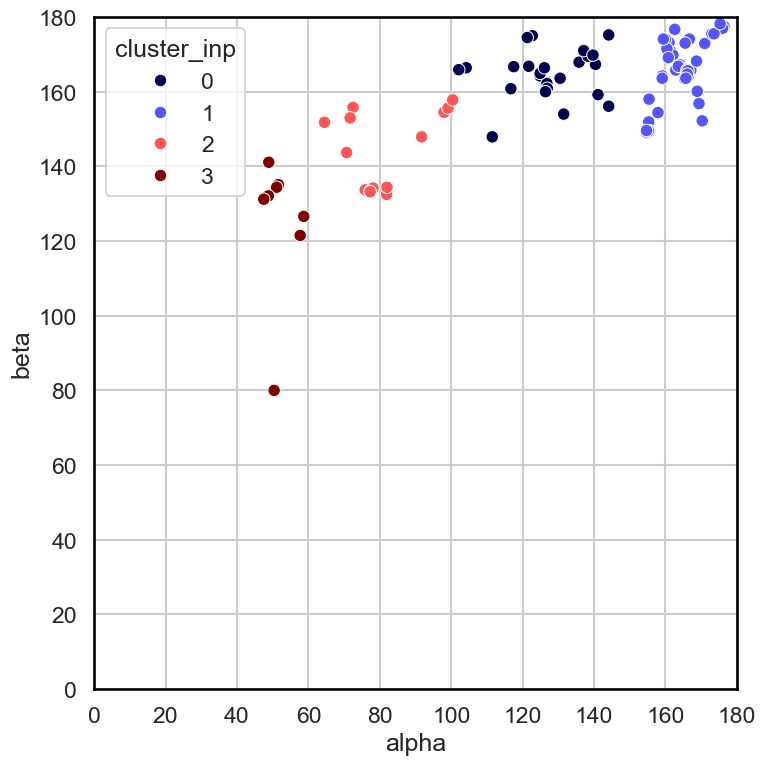

In [20]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})

fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='cluster_inp', palette='seismic')


plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)


plt.tight_layout()
plt.show()

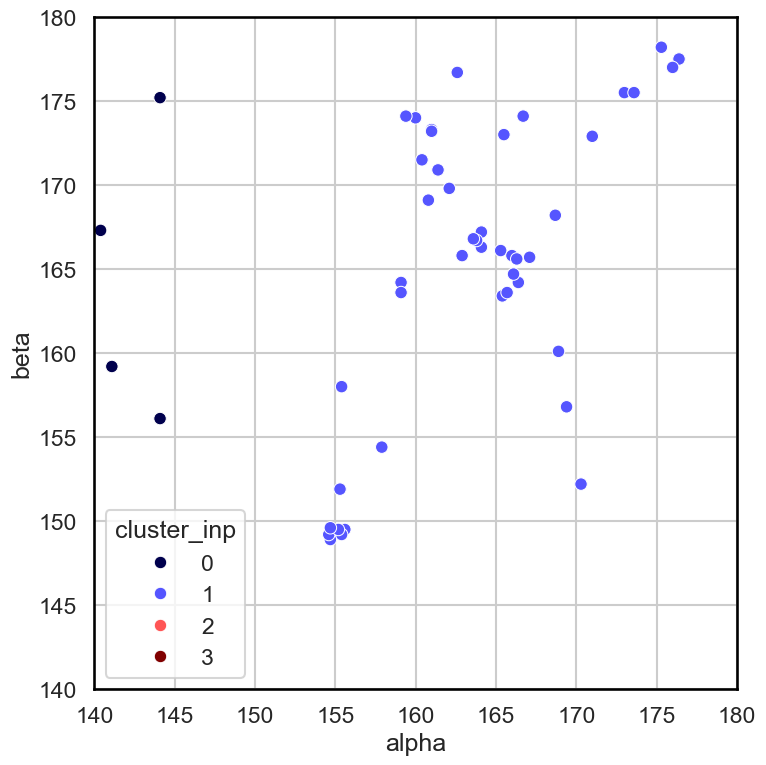

In [21]:
fig = plt.figure()
sns.scatterplot(data=inputs, x='alpha_inp', y='beta_inp', hue='cluster_inp', palette='seismic')


plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)


plt.tight_layout()
plt.show()

# Some statistics for each cluster

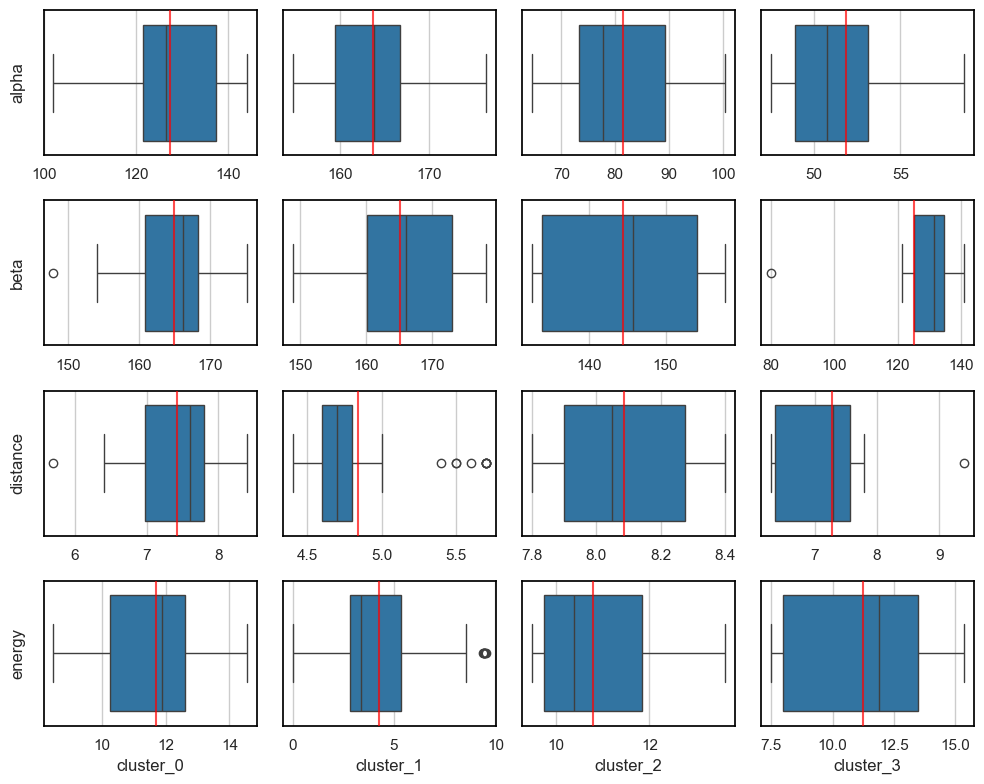

In [22]:
sns.set_context("notebook")
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,8), sharey=True)
axs = axs.flatten()

for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='alpha_inp', ax = axs[i])
    
    ax = axs[i]
    ax.set_xlabel('')
    ax.axvline(x=data['alpha_inp'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='beta_inp', ax = axs[i+4])
    
    ax = axs[i+4]
    ax.set_xlabel('')
    
    ax.axvline(x=data['beta_inp'].mean(), zorder=9, c='red', alpha=0.7)
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='distance_inp', ax = axs[i+8])
    
    ax = axs[i+8]
    ax.set_xlabel('')
    ax.axvline(x=data['distance_inp'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inputs[inputs['cluster_inp']==i]
    
    sns.boxplot(data=data, x='rel_energy_inp_kcal', ax = axs[i+12])
    
    ax = axs[i+12]
    ax.set_xlabel(f'cluster_{i}')
    ax.axvline(x=data['rel_energy_inp_kcal'].mean(), zorder=9, c='red', alpha=0.7)

ax = axs[0]
ax.set_ylabel('alpha')
ax = axs[4]
ax.set_ylabel('beta')
ax = axs[8]
ax.set_ylabel('distance')
ax = axs[12]
ax.set_ylabel('energy')
    
plt.tight_layout()
plt.show()


# Data collection of the output files

The algorithm iterates through folders `structure_x`, extracts geometry data from the xyz file, extracts R2SCAN-3c SP energy in vacuum and different solvents, extracts $\Delta G_{RRHO}$ values, and adds it as row to the pandas DataFrame along with structure.

In [23]:
# list of folders
folders = []
for dr in os.scandir():
    if dr.is_dir() and 'structure' in dr.name:
        folders.append(dr.name)

First we will create functions for each process (xyz file, out file etc.), then iterate through `folders` list executing those functions.

### Extracting geometry

In [24]:
def geometry_from_xyz(folder):
    pattern_xyz = 'struc_[0-9]+_r2scan_opt\.xyz'
    file_name = [i for i in os.listdir(f'{folder}/') if re.findall(pattern_xyz, i)][0] # get the name of correct xyz
    with open(f'{folder}/{file_name}', 'r', encoding='utf-8') as xyz:
        lines = xyz.readlines()
        no_of_atoms = int(lines[0][:-1]) # get number of atoms
        
        # get the lines containing the atoms we need
        
        n_coord = np.array([float(i) for i in lines[loc_n+1].strip().split()[1:]])
        cn_coord = np.array([float(i) for i in lines[loc_cn+1].strip().split()[1:]])
        s_coord = np.array([float(i) for i in lines[loc_s+1].strip().split()[1:]])
        cs_coord = np.array([float(i) for i in lines[loc_cs+1].strip().split()[1:]])
        
        # calculate the corresponding angles
        # alpha
        
        vector_n_cn = cn_coord - n_coord
        vector_n_cs = cs_coord - n_coord
        len_n_cn = np.sqrt(np.square(vector_n_cn).sum())
        len_n_cs = np.sqrt(np.square(vector_n_cs).sum())
        
        cos_a = np.dot(vector_n_cn, vector_n_cs)/(len_n_cn*len_n_cs)
        alpha = np.around(np.degrees(np.arccos(cos_a)), decimals=1)
        
        # beta
        
        vector_s_cn = cn_coord - s_coord
        vector_s_cs = cs_coord - s_coord
        len_s_cn = np.sqrt(np.square(vector_s_cn).sum())
        len_s_cs = np.sqrt(np.square(vector_s_cs).sum())
        
        cos_b = np.dot(vector_s_cs, vector_s_cn)/(len_s_cs*len_s_cn)
        beta = np.around(np.degrees(np.arccos(cos_b)), decimals=1)
        
        # distance
        dist = np.around(np.sqrt(np.square(n_coord - s_coord).sum()), decimals=1)
               
        
        
    return alpha, beta, dist

### SPE in vacuum

In [25]:
def r2scan_spe_vacuum(folder):
    pattern_out = 'struc_[0-9]+_r2scan_opt\.out'
    file_name = [i for i in os.listdir(f'{folder}/') if re.findall(pattern_out, i)][0] # get the name of correct out
    with open(f'{folder}/{file_name}', 'r', encoding='utf-8') as out:
        lines = out.readlines()
        for line in lines:
            if 'FINAL SINGLE POINT ENERGY' in line:
                energy_vacuum = re.findall(r'[-.\d]*[.][\d]+', line)
    return np.around(float(energy_vacuum[0]), decimals=6)

### $\Delta G_{RRHO}$ from single point hessian

In [26]:
def hess_reader(folder):
    pattern_out = 'struc_[0-9]+_r2scan_opt_bhess\.out'
    file_name = [i for i in os.listdir(f'{folder}/SPH/') if re.findall(pattern_out, i)][0] # get the name of correct out
    
    with open(f'{folder}/SPH/{file_name}', 'r', encoding='utf-8') as hess:
        lines = hess.readlines()
        for line in lines:
            if 'G(RRHO) contrib' in line:
                G_rrho = re.findall(r'[-.\d]*[.][\d]+', line)
        
    return np.around(float(G_rrho[0]), decimals=6)

### SPE for each solvent

In [27]:
def r2scan_spe_solvent(folder):
    energies = [folder]
    for solvent in solvents:
        with open(f'spe_outputs/{folder}/{solvent}/{folder}_r2scan_{solvent}.out', 'r', encoding='utf-8') as opt:
            lines = opt.readlines()
            for line in lines:
                if 'FINAL SINGLE POINT ENERGY' in line:
                    energy_sol = re.findall(r'[-.\d]*[.][\d]+', line)
                    energies.append(np.around(float(energy_sol[0]), decimals=6))
    return energies
                    

In [28]:
solvents = ['benzene', 'CH2Cl2', 'water']
en = []
for folder in os.listdir('spe_outputs'):
    energies = r2scan_spe_solvent(folder)
    en.append(energies)

In [29]:
solv_df = pd.DataFrame(en, columns=['name', 'benzene', 'CH2Cl2', 'water'])

In [30]:
solv_df

,name,benzene,CH2Cl2,water
0,structure_1,-5234.196081,-5234.220347,-5234.230701
1,structure_10,-5234.194546,-5234.218857,-5234.229282
2,structure_11,-5234.194818,-5234.217622,-5234.227280
3,structure_12,-5234.194460,-5234.218657,-5234.229027
4,structure_13,-5234.194443,-5234.218595,-5234.228947
...,...,...,...,...
81,structure_88,-5234.177160,-5234.206502,-5234.219097
82,structure_89,-5234.176778,-5234.206525,-5234.219368
83,structure_9,-5234.194399,-5234.218493,-5234.228815
84,structure_90,-5234.196122,-5234.220398,-5234.230789


### Iterating through the folders and combining the data

In [31]:
outputs = pd.DataFrame(columns=['name', 'alpha_opt', 'beta_opt', 'distance_opt', 'SPE_vac', 'dG'])
for folder in folders:
    alpha, beta, dist = geometry_from_xyz(folder)
    spe = r2scan_spe_vacuum(folder)
    dG = hess_reader(folder)
    
    outputs.loc[len(outputs.index)] = [folder, alpha, beta, dist, spe, dG]
    

In [32]:
outputs['energy_opt_vac'] = outputs['SPE_vac'] + outputs['dG']

In [33]:
outputs # contains the output data

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac
0,structure_1,165.8,170.9,4.6,-5234.172323,2.352028,-5231.820295
1,structure_10,161.4,166.0,4.7,-5234.170897,2.354113,-5231.816784
2,structure_11,166.4,154.0,4.8,-5234.172379,2.354249,-5231.818130
3,structure_12,161.2,165.0,4.7,-5234.170911,2.353992,-5231.816919
4,structure_13,161.2,165.0,4.7,-5234.170942,2.354048,-5231.816894
...,...,...,...,...,...,...,...
86,structure_88,94.2,151.7,7.8,-5234.148710,2.351982,-5231.796728
87,structure_89,74.0,133.8,7.8,-5234.148150,2.352458,-5231.795692
88,structure_9,161.1,164.6,4.7,-5234.170946,2.353970,-5231.816976
89,structure_90,163.7,176.6,4.6,-5234.172448,2.353647,-5231.818801


In [34]:
combined = outputs.merge(solv_df, on='name')

In [35]:
combined['benzene_opt'] = combined['benzene'] + combined['dG']
combined['CH2Cl2_opt'] = combined['CH2Cl2'] + combined['dG']
combined['water_opt'] = combined['water'] + combined['dG']

In [36]:
combined

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt
0,structure_1,165.8,170.9,4.6,-5234.172323,2.352028,-5231.820295,-5234.196081,-5234.220347,-5234.230701,-5231.844053,-5231.868319,-5231.878673
1,structure_10,161.4,166.0,4.7,-5234.170897,2.354113,-5231.816784,-5234.194546,-5234.218857,-5234.229282,-5231.840433,-5231.864744,-5231.875169
2,structure_11,166.4,154.0,4.8,-5234.172379,2.354249,-5231.818130,-5234.194818,-5234.217622,-5234.227280,-5231.840569,-5231.863373,-5231.873031
3,structure_12,161.2,165.0,4.7,-5234.170911,2.353992,-5231.816919,-5234.194460,-5234.218657,-5234.229027,-5231.840468,-5231.864665,-5231.875035
4,structure_13,161.2,165.0,4.7,-5234.170942,2.354048,-5231.816894,-5234.194443,-5234.218595,-5234.228947,-5231.840395,-5231.864547,-5231.874899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,structure_88,94.2,151.7,7.8,-5234.148710,2.351982,-5231.796728,-5234.177160,-5234.206502,-5234.219097,-5231.825178,-5231.854520,-5231.867115
82,structure_89,74.0,133.8,7.8,-5234.148150,2.352458,-5231.795692,-5234.176778,-5234.206525,-5234.219368,-5231.824320,-5231.854067,-5231.866910
83,structure_9,161.1,164.6,4.7,-5234.170946,2.353970,-5231.816976,-5234.194399,-5234.218493,-5234.228815,-5231.840429,-5231.864523,-5231.874845
84,structure_90,163.7,176.6,4.6,-5234.172448,2.353647,-5231.818801,-5234.196122,-5234.220398,-5234.230789,-5231.842475,-5231.866751,-5231.877142


# Manually get cation and anion r2scan energies 

In [37]:
cation_dG = 1.325192904452
cation_spe_vac = np.around(cation_dG - 2624.429779910052, decimals=6)
cation_spe_benzene = np.around(cation_dG - 2624.463743718003, decimals=6)
cation_spe_CH2Cl2 = np.around(cation_dG - 2624.485228105365, decimals=6)
cation_spe_water = np.around(cation_dG - 2624.491975392355, decimals=6)

In [38]:
anion_dG = 0.993800
anion_spe_vac = np.around(anion_dG - 2609.616974162284, decimals=6)
anion_spe_benzene = np.around(anion_dG - 2609.655478543323, decimals=6)
anion_spe_CH2Cl2 = np.around(anion_dG - 2609.692657286503, decimals=6)
anion_spe_water = np.around(anion_dG - 2609.707742943956, decimals=6)

In [39]:
combined['association_vacuum'] = (combined['energy_opt_vac'] - (cation_spe_vac+anion_spe_vac))*627.509
combined['association_benzene'] = (combined['benzene_opt'] - (cation_spe_benzene+anion_spe_benzene))*627.509
combined['association_CH2Cl2'] = (combined['CH2Cl2_opt'] - (cation_spe_CH2Cl2+anion_spe_CH2Cl2))*627.509
combined['association_water'] = (combined['water_opt'] - (cation_spe_water+anion_spe_water))*627.509

In [40]:
combined

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt,association_vacuum,association_benzene,association_CH2Cl2,association_water
0,structure_1,165.8,170.9,4.6,-5234.172323,2.352028,-5231.820295,-5234.196081,-5234.220347,-5234.230701,-5231.844053,-5231.868319,-5231.878673,-58.065918,-27.499327,-5.915527,1.287648
1,structure_10,161.4,166.0,4.7,-5234.170897,2.354113,-5231.816784,-5234.194546,-5234.218857,-5234.229282,-5231.840433,-5231.864744,-5231.875169,-55.862734,-25.227744,-3.672183,3.486440
2,structure_11,166.4,154.0,4.8,-5234.172379,2.354249,-5231.818130,-5234.194818,-5234.217622,-5234.227280,-5231.840569,-5231.863373,-5231.873031,-56.707361,-25.313086,-2.811868,4.828054
3,structure_12,161.2,165.0,4.7,-5234.170911,2.353992,-5231.816919,-5234.194460,-5234.218657,-5234.229027,-5231.840468,-5231.864665,-5231.875035,-55.947447,-25.249707,-3.622609,3.570526
4,structure_13,161.2,165.0,4.7,-5234.170942,2.354048,-5231.816894,-5234.194443,-5234.218595,-5234.228947,-5231.840395,-5231.864547,-5231.874899,-55.931760,-25.203899,-3.548563,3.655867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,structure_88,94.2,151.7,7.8,-5234.148710,2.351982,-5231.796728,-5234.177160,-5234.206502,-5234.219097,-5231.825178,-5231.854520,-5231.867115,-43.277413,-15.655095,2.743469,8.540397
82,structure_89,74.0,133.8,7.8,-5234.148150,2.352458,-5231.795692,-5234.176778,-5234.206525,-5234.219368,-5231.824320,-5231.854067,-5231.866910,-42.627314,-15.116692,3.027731,8.669037
83,structure_9,161.1,164.6,4.7,-5234.170946,2.353970,-5231.816976,-5234.194399,-5234.218493,-5234.228815,-5231.840429,-5231.864523,-5231.874845,-55.983215,-25.225234,-3.533503,3.689753
84,structure_90,163.7,176.6,4.6,-5234.172448,2.353647,-5231.818801,-5234.196122,-5234.220398,-5234.230789,-5231.842475,-5231.866751,-5231.877142,-57.128419,-26.509118,-4.931593,2.248365


In [41]:
combined.to_excel('optimized_Cy.xlsx')

In [42]:
combined.sort_values(by='association_CH2Cl2').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,benzene_opt,CH2Cl2_opt,water_opt,association_vacuum,association_benzene,association_CH2Cl2,association_water
0,structure_1,165.8,170.9,4.6,-5234.172323,2.352028,-5231.820295,-5234.196081,-5234.220347,-5234.230701,-5231.844053,-5231.868319,-5231.878673,-58.065918,-27.499327,-5.915527,1.287648
43,structure_5,163.0,176.3,4.6,-5234.172566,2.353266,-5231.819300,-5234.196271,-5234.220568,-5234.230966,-5231.843005,-5231.867302,-5231.877700,-57.441546,-26.841697,-5.277351,1.898215
62,structure_7,163.1,176.4,4.6,-5234.172570,2.353261,-5231.819309,-5234.196256,-5234.220532,-5234.230921,-5231.842995,-5231.867271,-5231.877660,-57.447194,-26.835422,-5.257898,1.923315
61,structure_69,159.0,179.1,4.6,-5234.171925,2.352490,-5231.819435,-5234.195531,-5234.219698,-5234.230010,-5231.843041,-5231.867208,-5231.877520,-57.526260,-26.864288,-5.218365,2.011166
84,structure_90,163.7,176.6,4.6,-5234.172448,2.353647,-5231.818801,-5234.196122,-5234.220398,-5234.230789,-5231.842475,-5231.866751,-5231.877142,-57.128419,-26.509118,-4.931593,2.248365
54,structure_6,166.5,176.7,4.6,-5234.172678,2.353689,-5231.818989,-5234.196222,-5234.220357,-5234.230689,-5231.842533,-5231.866668,-5231.877000,-57.246391,-26.545513,-4.879510,2.337471
60,structure_68,158.0,176.5,4.6,-5234.173102,2.352662,-5231.820440,-5234.195650,-5234.218746,-5234.228616,-5231.842988,-5231.866084,-5231.875954,-58.156907,-26.831030,-4.513045,2.993845
47,structure_53,158.8,172.2,4.6,-5234.172387,2.354140,-5231.818247,-5234.195867,-5234.219973,-5234.230314,-5231.841727,-5231.865833,-5231.876174,-56.780779,-26.039741,-4.355540,2.855793
25,structure_32,158.9,171.8,4.6,-5234.172374,2.354087,-5231.818287,-5234.195714,-5234.219662,-5234.229928,-5231.841627,-5231.865575,-5231.875841,-56.805880,-25.976990,-4.193643,3.064754
66,structure_73,158.9,173.7,4.7,-5234.173005,2.352947,-5231.820058,-5234.195448,-5234.218306,-5234.228006,-5231.842501,-5231.865359,-5231.875059,-57.917198,-26.525433,-4.058101,3.555466


# Combine inputs and outputs

In [43]:
inp_out = combined.merge(inputs, on='name')

In [44]:
inp_out.sort_values(by='association_benzene').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,association_vacuum,association_benzene,association_CH2Cl2,association_water,alpha_inp,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp
0,structure_1,165.8,170.9,4.6,-5234.172323,2.352028,-5231.820295,-5234.196081,-5234.220347,-5234.230701,...,-58.065918,-27.499327,-5.915527,1.287648,166.7,174.1,4.5,-352.587492,0.000000,1
61,structure_69,159.0,179.1,4.6,-5234.171925,2.352490,-5231.819435,-5234.195531,-5234.219698,-5234.230010,...,-57.526260,-26.864288,-5.218365,2.011166,137.1,171.0,6.8,-352.569006,11.600439,0
43,structure_5,163.0,176.3,4.6,-5234.172566,2.353266,-5231.819300,-5234.196271,-5234.220568,-5234.230966,...,-57.441546,-26.841697,-5.277351,1.898215,173.0,175.5,4.5,-352.585808,1.056800,1
62,structure_7,163.1,176.4,4.6,-5234.172570,2.353261,-5231.819309,-5234.196256,-5234.220532,-5234.230921,...,-57.447194,-26.835422,-5.257898,1.923315,175.3,178.2,4.4,-352.584509,1.871702,1
60,structure_68,158.0,176.5,4.6,-5234.173102,2.352662,-5231.820440,-5234.195650,-5234.218746,-5234.228616,...,-58.156907,-26.831030,-4.513045,2.993845,138.3,169.5,6.5,-352.569070,11.560134,0
54,structure_6,166.5,176.7,4.6,-5234.172678,2.353689,-5231.818989,-5234.196222,-5234.220357,-5234.230689,...,-57.246391,-26.545513,-4.879510,2.337471,173.6,175.5,4.5,-352.585634,1.165912,1
66,structure_73,158.9,173.7,4.7,-5234.173005,2.352947,-5231.820058,-5234.195448,-5234.218306,-5234.228006,...,-57.917198,-26.525433,-4.058101,3.555466,130.5,163.6,7.6,-352.568536,11.895312,0
84,structure_90,163.7,176.6,4.6,-5234.172448,2.353647,-5231.818801,-5234.196122,-5234.220398,-5234.230789,...,-57.128419,-26.509118,-4.931593,2.248365,144.1,156.1,7.0,-352.564311,14.546292,0
73,structure_8,160.0,163.4,4.6,-5234.173580,2.354120,-5231.819460,-5234.195873,-5234.218663,-5234.228393,...,-57.541948,-26.056056,-3.546053,4.048688,161.4,170.9,4.6,-352.584268,2.023346,1
47,structure_53,158.8,172.2,4.6,-5234.172387,2.354140,-5231.818247,-5234.195867,-5234.219973,-5234.230314,...,-56.780779,-26.039741,-4.355540,2.855793,144.1,175.2,5.7,-352.572269,9.552557,0


In [45]:
q = inp_out['alpha_opt'] - inp_out['alpha_inp']
q[24]

-6.399999999999977

In [46]:
inp_out.to_excel('comparison_Cy.xlsx')

In [47]:
inp_out['rel_vac'] = inp_out['association_vacuum'] - inp_out['association_vacuum'].min()
inp_out['rel_benzene'] = inp_out['association_benzene'] - inp_out['association_benzene'].min()
inp_out['rel_CH2Cl2'] = inp_out['association_CH2Cl2'] - inp_out['association_CH2Cl2'].min()
inp_out['rel_water'] = inp_out['association_water'] - inp_out['association_water'].min()

# Analysis of the opt data

Plot alpha vs beta

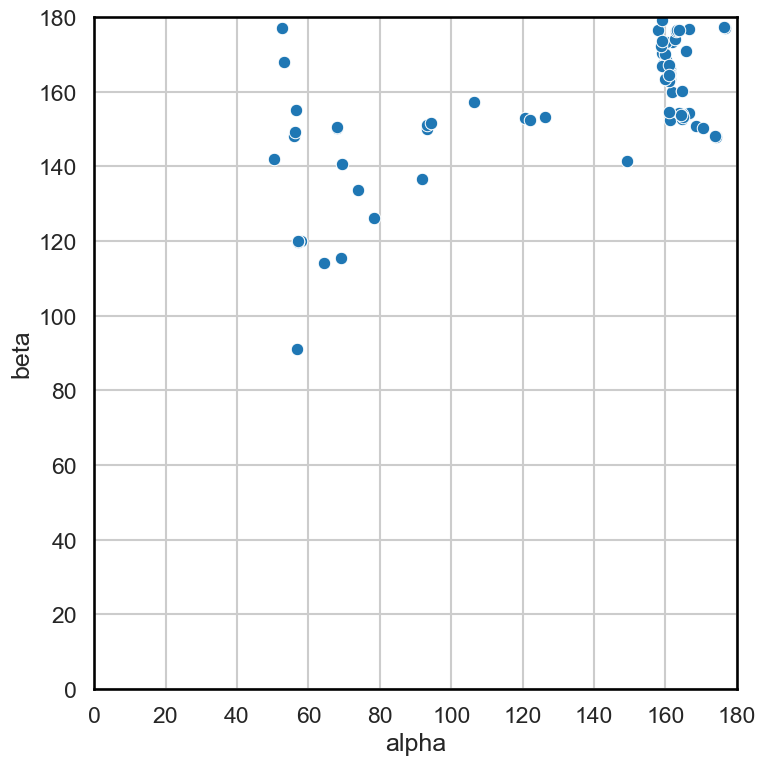

In [48]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

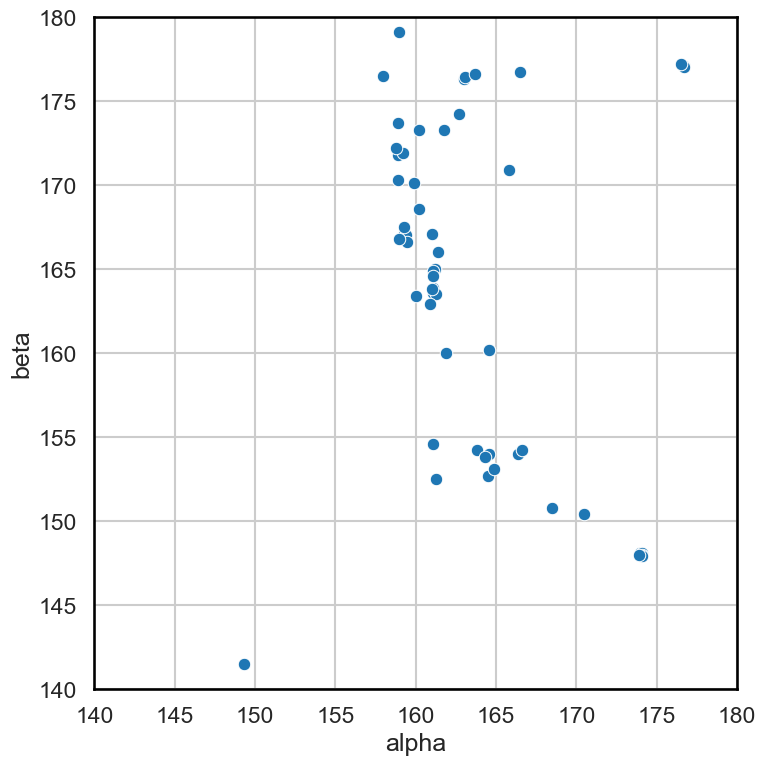

In [49]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

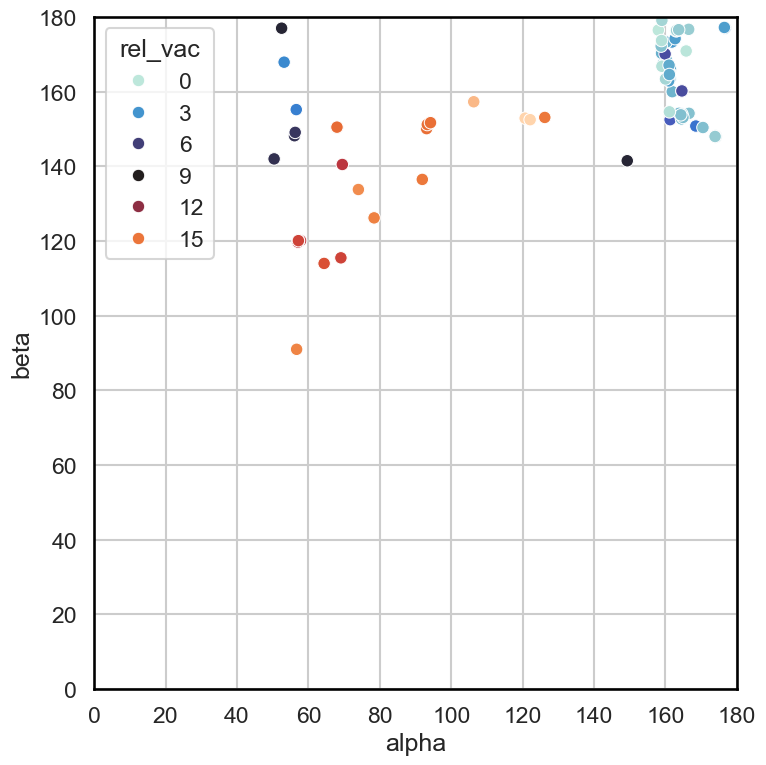

In [50]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_vac', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

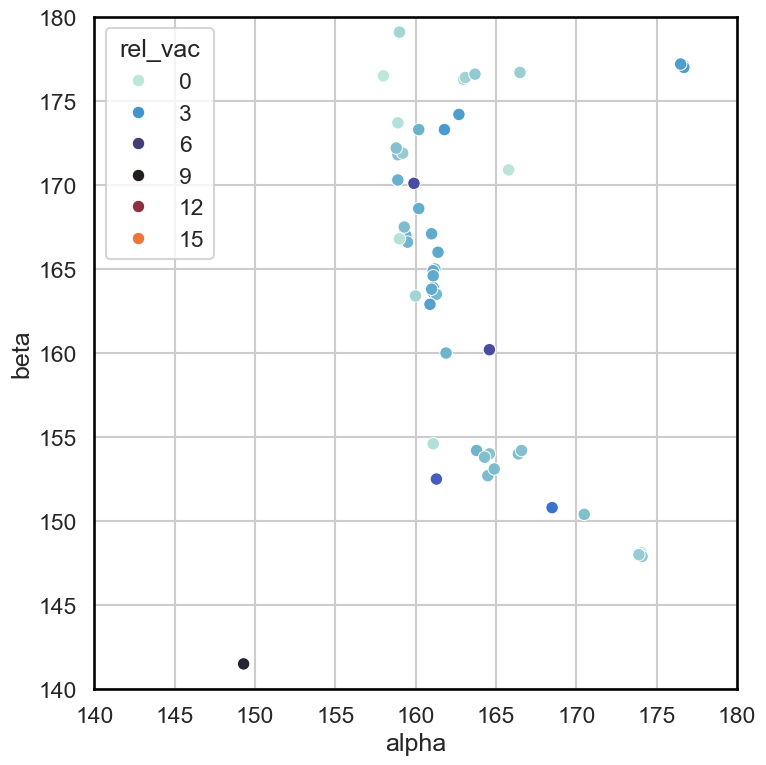

In [51]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_vac', palette='icefire')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)

plt.tight_layout()
plt.show()

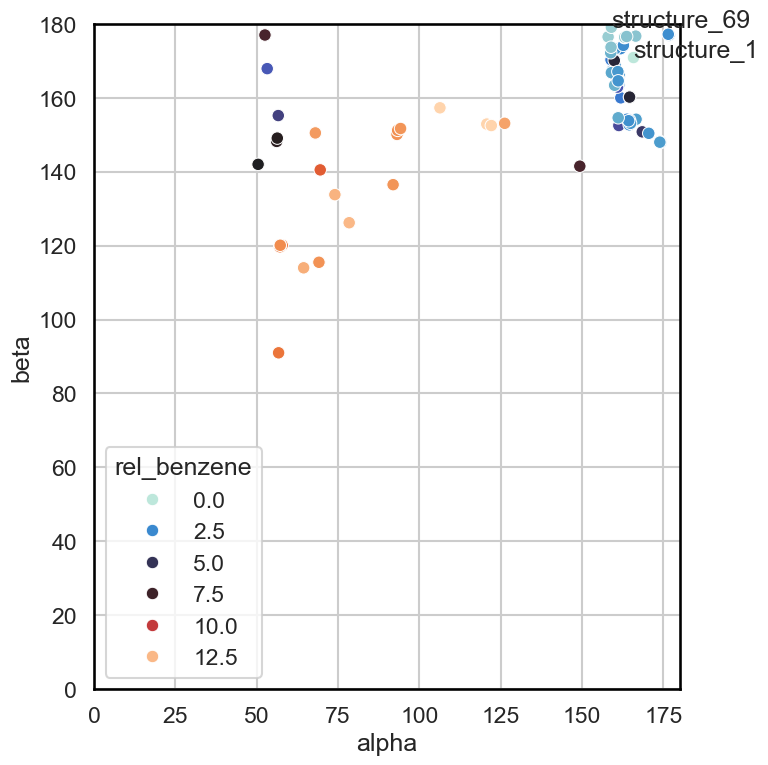

In [52]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.annotate(inp_out.iloc[0,0], (inp_out.iloc[0, 1], inp_out.iloc[0,2]))
plt.annotate(inp_out.iloc[61,0], (inp_out.iloc[61, 1], inp_out.iloc[61,2]))
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

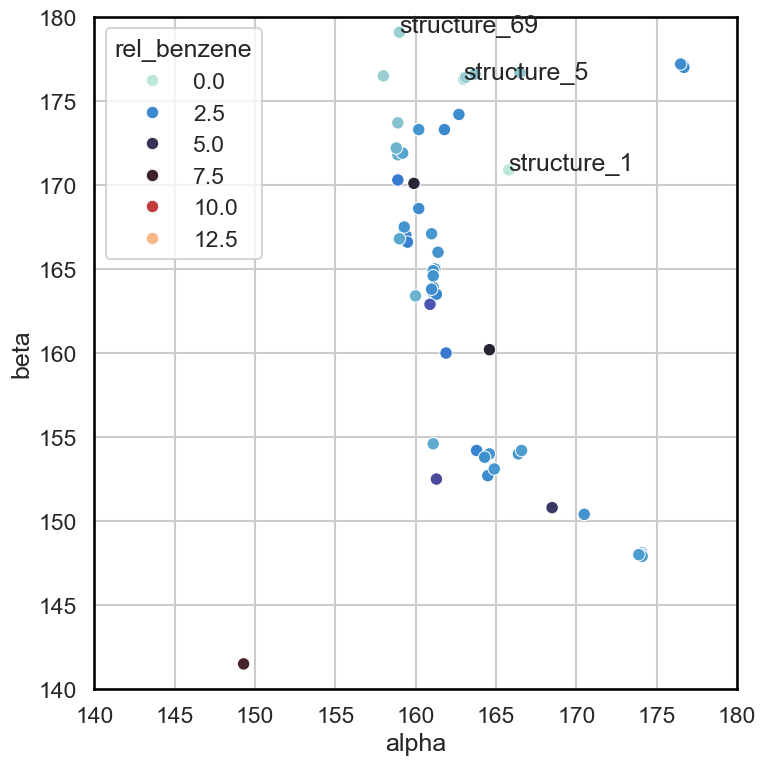

In [53]:
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.annotate(inp_out.iloc[0,0], (inp_out.iloc[0, 1], inp_out.iloc[0,2]))
plt.annotate(inp_out.iloc[61,0], (inp_out.iloc[61, 1], inp_out.iloc[61,2]))
plt.annotate(inp_out.iloc[43,0], (inp_out.iloc[43, 1], inp_out.iloc[43,2]))
plt.tight_layout()
plt.show()

# Some statistics on the output data

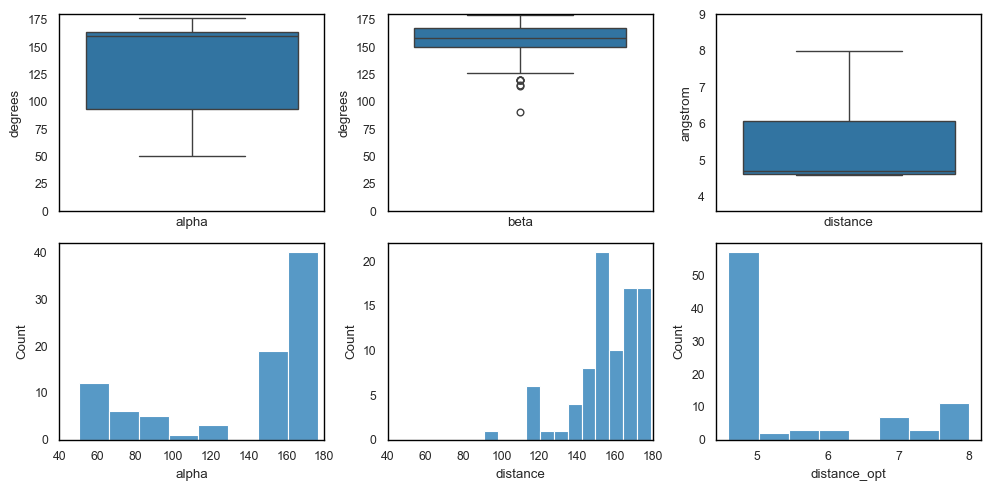

In [54]:
sns.set_context("paper")
sns.set_style("white", {"axes.edgecolor": "black"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axs = axs.flatten()

sns.boxplot(inp_out['alpha_opt'], ax=axs[0])
ax=axs[0]
ax.set_ylabel('degrees')
ax.set_xlabel('alpha')
ax.set_ylim([0,180])
ax.set_xticks([])

sns.boxplot(inp_out['beta_opt'], ax=axs[1])
ax=axs[1]
ax.set_ylabel('degrees')
ax.set_ylim([0,180])
ax.set_xlabel('beta')
ax.set_xticks([])

sns.boxplot(inp_out['distance_opt'], ax=axs[2])
ax=axs[2]
ax.set_ylabel('angstrom')
ax.set_ylim([inp_out['distance_opt'].min()-1, inp_out['distance_opt'].max()+1])
ax.set_xlabel('distance')
ax.set_xticks([])

sns.histplot(inp_out['alpha_opt'], ax=axs[3])
ax=axs[3]
ax.set_xlim([40,180])
ax.set_xlabel('alpha')

sns.histplot(inp_out['beta_opt'], ax=axs[4])
ax=axs[4]
ax.set_xlim([40,180])
ax.set_xlabel('beta')

sns.histplot(inp_out['distance_opt'], ax=axs[5])
ax.set_xlabel('distance')
plt.tight_layout()
plt.show()

# Clustering of output data

In [55]:
warnings.filterwarnings('ignore')
inertias = []
for i in range(1,11): # more than 10 clusters make no sense for 93 samples
    model = KMeans(n_clusters=i, random_state=123, max_iter=1000)
    model.fit(inp_out[['alpha_opt', 'beta_opt']])
    inertias.append(model.inertia_)

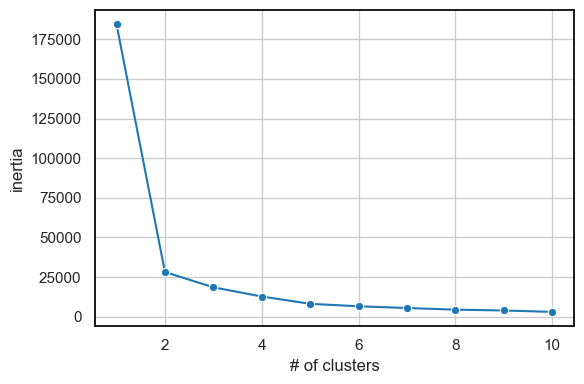

In [56]:
sns.set_context("notebook")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure(figsize=(6,4))
sns.lineplot(x=range(1,11), y=inertias, markers=True, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.tight_layout()
plt.show()

In [57]:
model = KMeans(n_clusters=4, random_state=123, max_iter=1000)
model.fit(inp_out[['alpha_opt', 'beta_opt']])
inp_out['cluster_opt'] = model.labels_

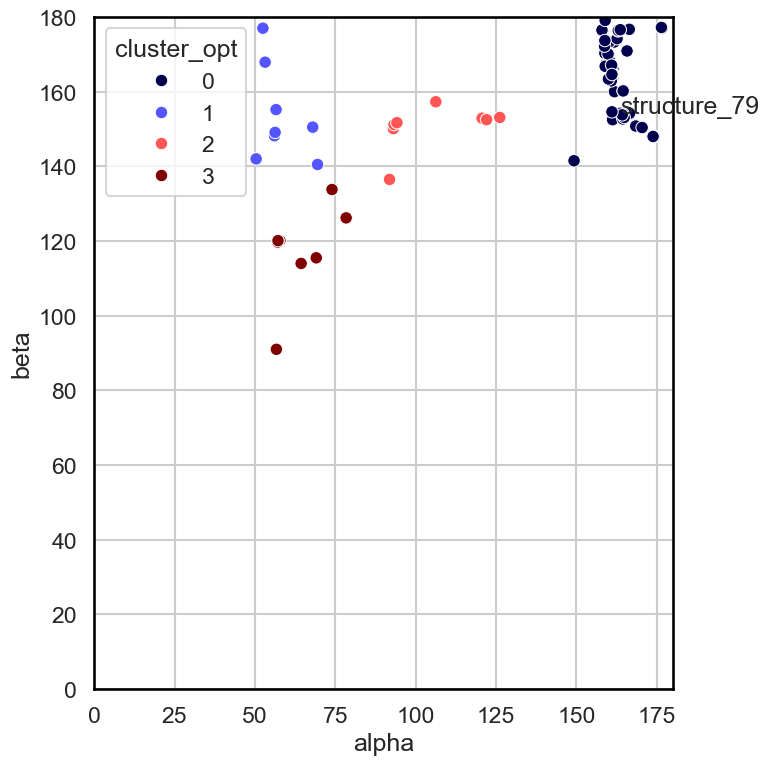

In [58]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=inp_out, x='alpha_opt', y='beta_opt', hue='cluster_opt', palette='seismic')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.annotate(inp_out.iloc[72,0], (inp_out.iloc[72,1], inp_out.iloc[72,2]))
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

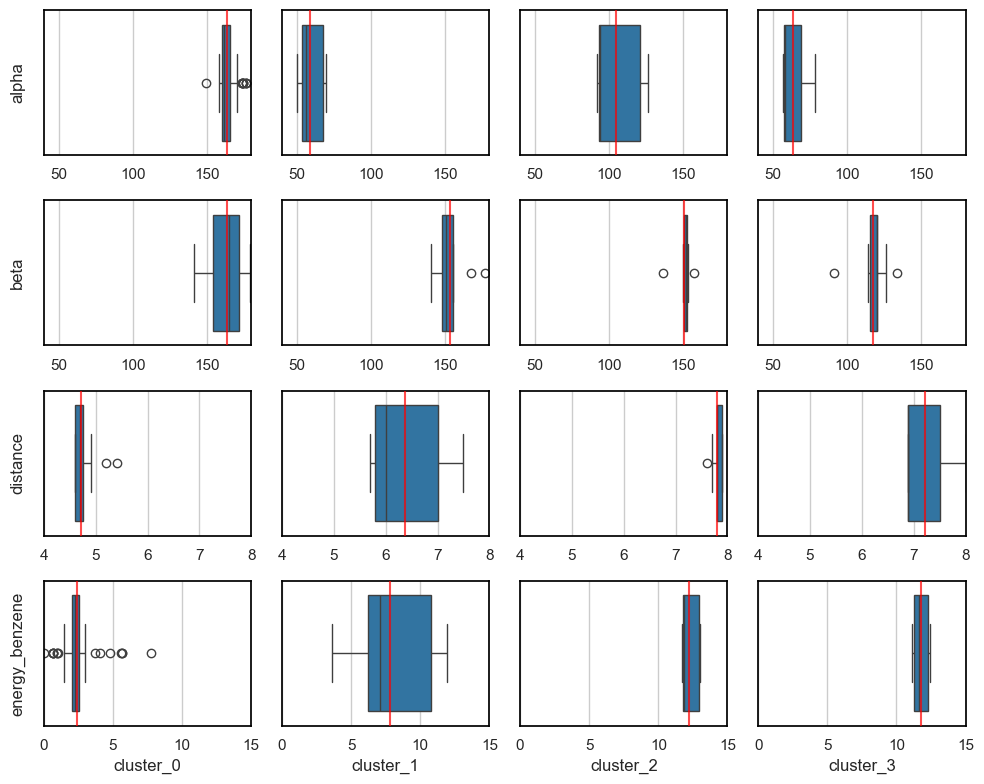

In [59]:
sns.set_context("notebook")
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,8), sharey=True)
axs = axs.flatten()

for i in range(4):
    data = inp_out[inp_out['cluster_opt']==i]
    
    sns.boxplot(data=data, x='alpha_opt', ax = axs[i])
    
    ax = axs[i]
    ax.set_xlabel('')
    ax.set_xlim([40,180])
    ax.axvline(x=data['alpha_opt'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inp_out[inp_out['cluster_opt']==i]
    
    sns.boxplot(data=data, x='beta_opt', ax = axs[i+4])
    
    ax = axs[i+4]
    ax.set_xlim([40,180])
    ax.set_xlabel('')
    
    ax.axvline(x=data['beta_opt'].mean(), zorder=9, c='red', alpha=0.7)
for i in range(4):
    data = inp_out[inp_out['cluster_opt']==i]
    
    sns.boxplot(data=data, x='distance_opt', ax = axs[i+8])
    
    ax = axs[i+8]
    ax.set_xlabel('')
    ax.set_xlim([4,8])
    ax.axvline(x=data['distance_opt'].mean(), zorder=9, c='red', alpha=0.7)
    
for i in range(4):
    data = inp_out[inp_out['cluster_opt']==i]
    
    sns.boxplot(data=data, x='rel_benzene', ax = axs[i+12])
    
    ax = axs[i+12]
    ax.set_xlabel(f'cluster_{i}')
    ax.set_xlim([0,15])
    ax.axvline(x=data['rel_benzene'].mean(), zorder=9, c='red', alpha=0.7)

ax = axs[0]
ax.set_ylabel('alpha')
ax = axs[4]
ax.set_ylabel('beta')
ax = axs[8]
ax.set_ylabel('distance')
ax = axs[12]
ax.set_ylabel('energy_benzene')
    
plt.tight_layout()
plt.show()

# Comparison of data

In [60]:
geometry = inp_out[['name', 'alpha_inp', 'beta_inp', 'alpha_opt', 'beta_opt', 'rel_benzene', 'rel_energy_inp_kcal', 'cluster_inp']]

In [61]:
geometry['dA'] = geometry['alpha_opt'] - geometry['alpha_inp']
geometry['dB'] = geometry['beta_opt'] - geometry['beta_inp']
geometry['dE'] = geometry['rel_benzene'] - geometry['rel_energy_inp_kcal']

In [62]:
geometry.sort_values('rel_benzene').head(10)

,name,alpha_inp,beta_inp,alpha_opt,beta_opt,rel_benzene,rel_energy_inp_kcal,cluster_inp,dA,dB,dE
0,structure_1,166.7,174.1,165.8,170.9,0.000000,0.000000,1,-0.9,-3.2,0.000000
61,structure_69,137.1,171.0,159.0,179.1,0.635039,11.600439,0,21.9,8.1,-10.965400
43,structure_5,173.0,175.5,163.0,176.3,0.657629,1.056800,1,-10.0,0.8,-0.399171
62,structure_7,175.3,178.2,163.1,176.4,0.663905,1.871702,1,-12.2,-1.8,-1.207798
60,structure_68,138.3,169.5,158.0,176.5,0.668297,11.560134,0,19.7,7.0,-10.891837
54,structure_6,173.6,175.5,166.5,176.7,0.953814,1.165912,1,-7.1,1.2,-0.212098
66,structure_73,130.5,163.6,158.9,173.7,0.973894,11.895312,0,28.4,10.1,-10.921418
84,structure_90,144.1,156.1,163.7,176.6,0.990209,14.546292,0,19.6,20.5,-13.556083
73,structure_8,161.4,170.9,160.0,163.4,1.443271,2.023346,1,-1.4,-7.5,-0.580076
47,structure_53,144.1,175.2,158.8,172.2,1.459586,9.552557,0,14.7,-3.0,-8.092971


In [63]:
geometry[geometry['dA'] == geometry['dA'].min()]

,name,alpha_inp,beta_inp,alpha_opt,beta_opt,rel_benzene,rel_energy_inp_kcal,cluster_inp,dA,dB,dE
82,structure_89,102.1,165.9,74.0,133.8,12.382635,14.09955,0,-28.1,-32.1,-1.716915


In [64]:
inp_out[inp_out['alpha_opt']<100].sort_values('association_vacuum').head(10)

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
77,structure_84,53.2,167.9,6.0,-5234.167744,2.352617,-5231.815127,-5234.190908,-5234.215076,-5234.225548,...,132.1,7.5,-352.566257,13.325034,3,3.333955,3.615707,3.677203,3.603157,1
68,structure_75,56.6,155.2,5.7,-5234.170467,2.355878,-5231.814589,-5234.192900,-5234.216331,-5234.226502,...,126.6,7.2,-352.568226,12.089463,3,3.671555,4.412016,4.935986,5.050820,1
35,structure_41,56.3,149.1,5.8,-5234.164471,2.354378,-5231.810093,-5234.187573,-5234.211692,-5234.222163,...,134.4,6.3,-352.574723,8.012926,3,6.492836,6.813493,6.905737,6.832318,1
34,structure_40,56.1,148.2,5.8,-5234.164220,2.354467,-5231.809753,-5234.187259,-5234.211337,-5234.221798,...,135.1,6.3,-352.574847,7.934832,3,6.706189,7.066379,7.184351,7.117207,1
31,structure_38,50.4,142.0,5.9,-5234.164178,2.354623,-5231.809555,-5234.188710,-5234.214446,-5234.225674,...,141.1,6.4,-352.575569,7.481840,3,6.830435,6.253755,5.331316,4.782874,1
80,structure_87,52.5,177.0,6.1,-5234.164848,2.356465,-5231.808383,-5234.188191,-5234.212472,-5234.222982,...,131.2,7.8,-352.565335,13.903792,3,7.565876,7.735303,7.725891,7.627999,1
78,structure_85,69.5,140.5,7.0,-5234.153561,2.354034,-5231.799527,-5234.180911,-5234.209067,-5234.221141,...,143.7,7.8,-352.565791,13.617686,2,13.123096,10.778095,8.337085,7.257769,1
69,structure_76,57.1,119.7,6.9,-5234.152546,2.353046,-5231.799500,-5234.179320,-5234.206982,-5234.218885,...,133.3,8.0,-352.568154,12.134637,2,13.140038,11.156483,9.025462,8.053451,3
63,structure_70,57.8,120.1,6.9,-5234.152642,2.353169,-5231.799473,-5234.179333,-5234.206903,-5234.218762,...,121.5,7.4,-352.568815,11.719929,3,13.156981,11.225509,9.152219,8.207818,3
67,structure_74,57.2,120.1,6.9,-5234.152595,2.353873,-5231.798722,-5234.179355,-5234.206992,-5234.218884,...,133.7,7.9,-352.568332,12.023129,2,13.628240,11.653470,9.538137,8.573028,3


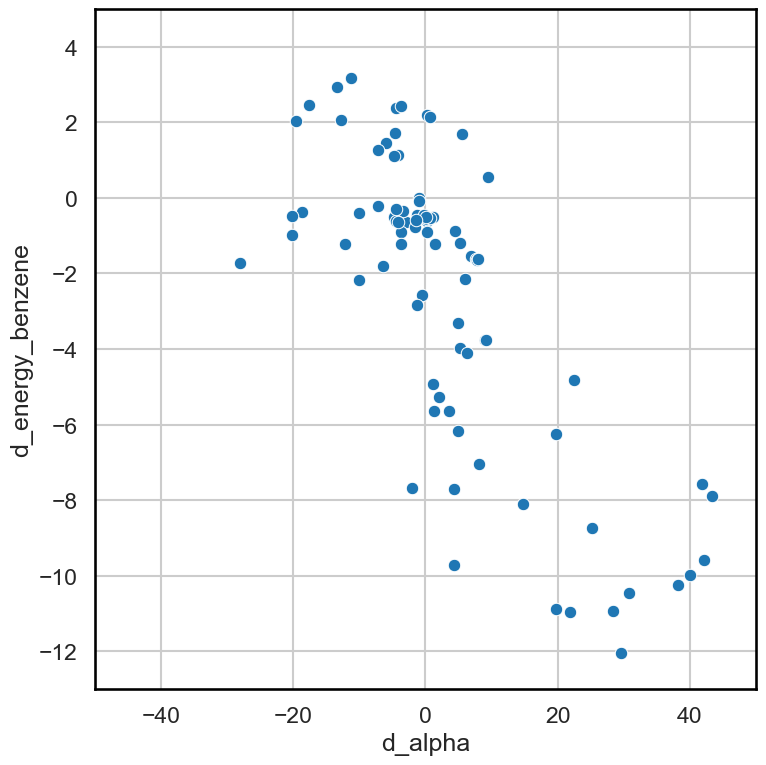

In [65]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=geometry, x='dA', y='dE')
plt.xlim([-50, 50])
plt.ylim([-13, 5])

plt.xlabel('d_alpha')
plt.ylabel('d_energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

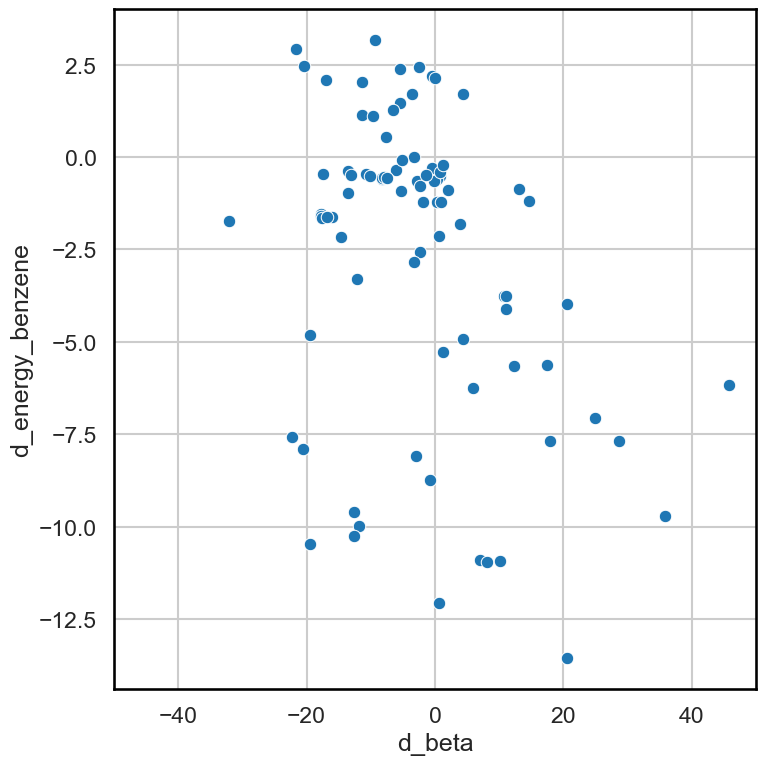

In [66]:
fig = plt.figure()
sns.scatterplot(data=geometry, x='dB', y='dE')
plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('d_beta')
plt.ylabel('d_energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

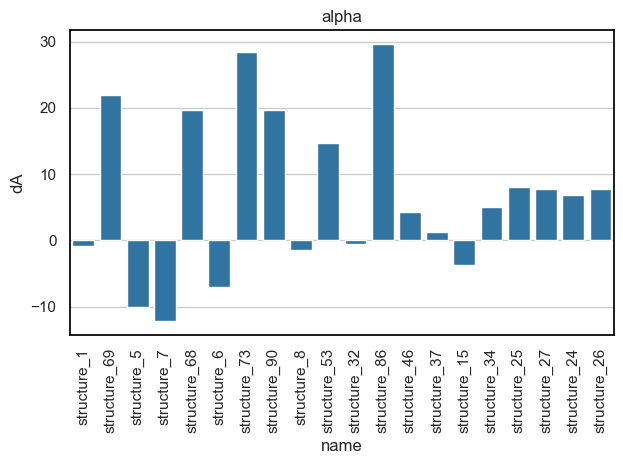

In [67]:
sns.set_context("notebook")
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[0:20], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

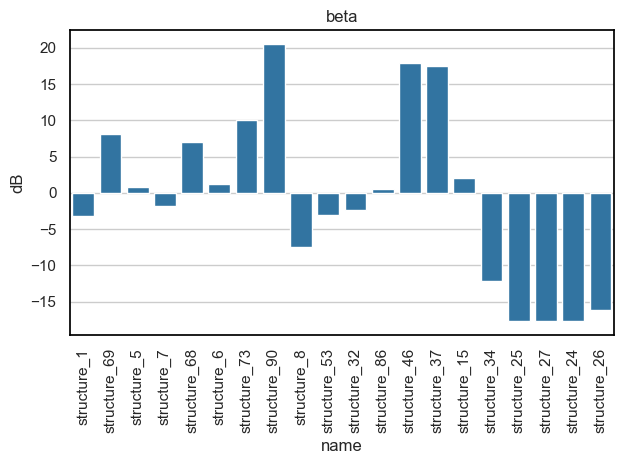

In [68]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[0:20], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

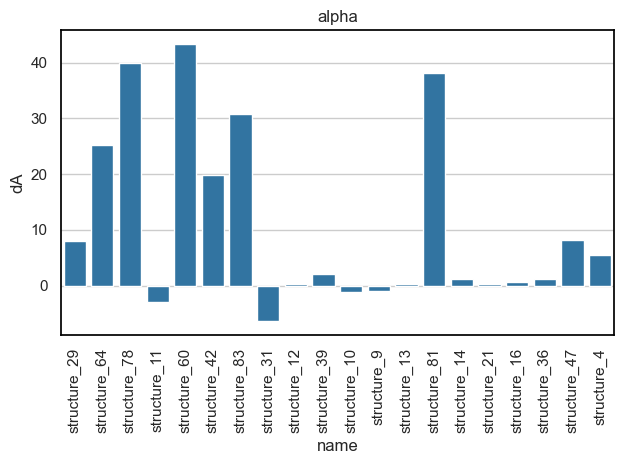

In [69]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[20:40], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

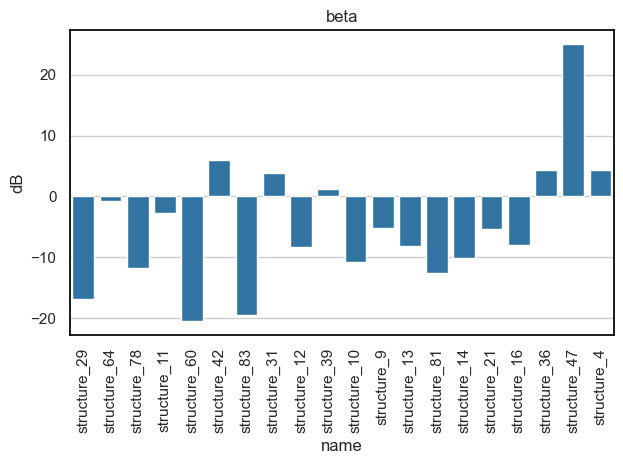

In [70]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[20:40], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

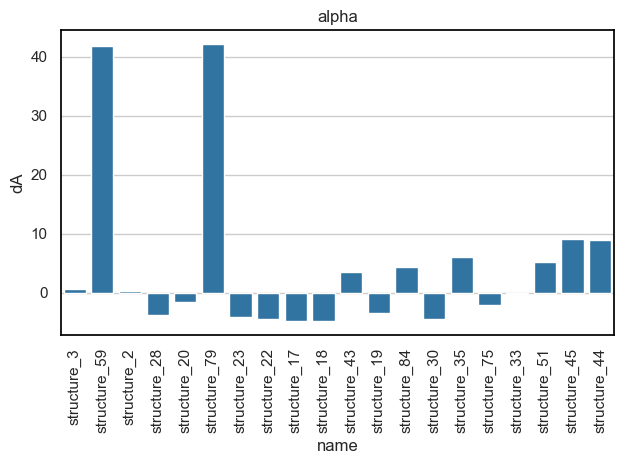

In [71]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[40:60], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

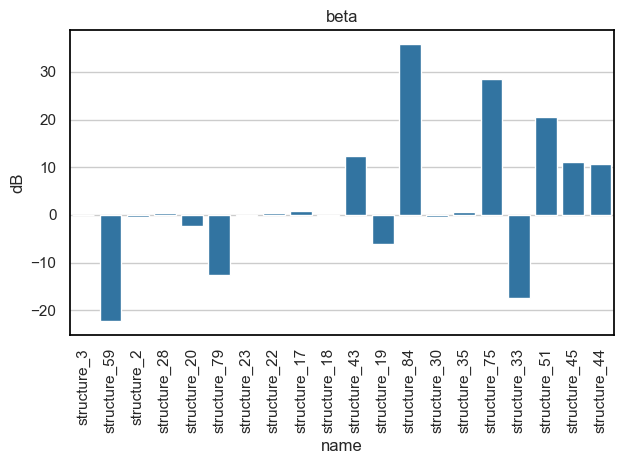

In [72]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[40:60], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

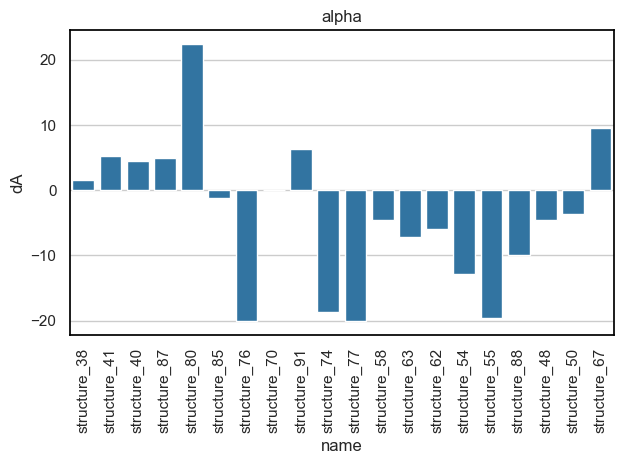

In [73]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[60:80], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

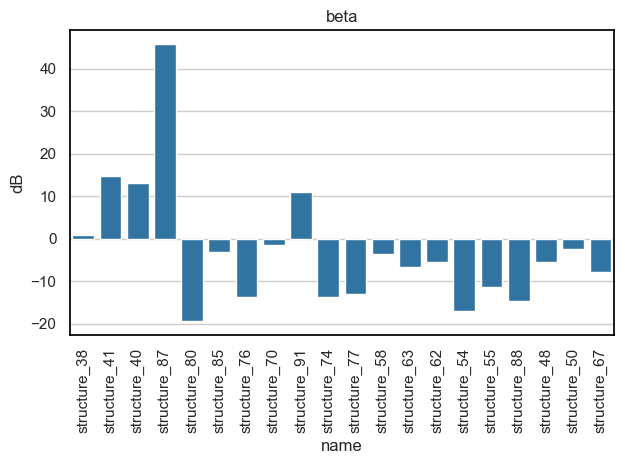

In [74]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[60:80], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

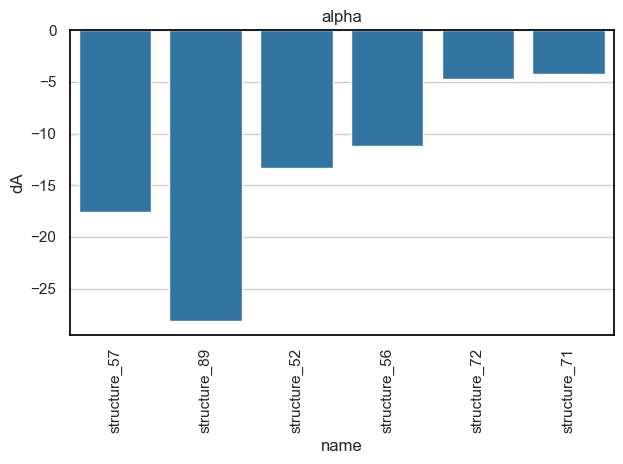

In [75]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[80:], x='name', y='dA')
plt.xticks(rotation='vertical')
plt.title('alpha')
plt.tight_layout()
plt.show()

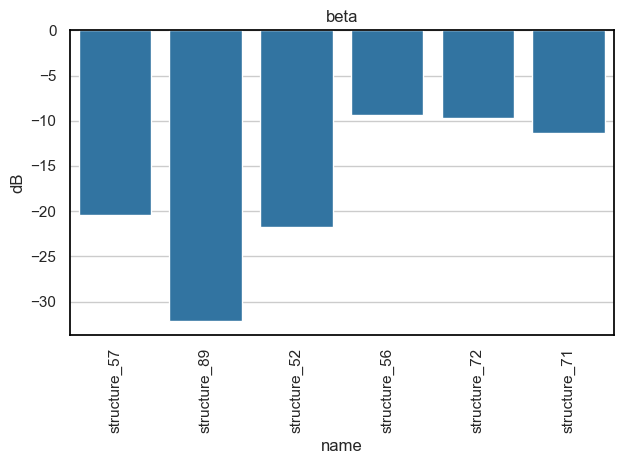

In [76]:
fig = plt.figure()
sns.barplot(data=geometry.sort_values('rel_benzene')[80:], x='name', y='dB')
plt.xticks(rotation='vertical')
plt.title('beta')
plt.tight_layout()
plt.show()

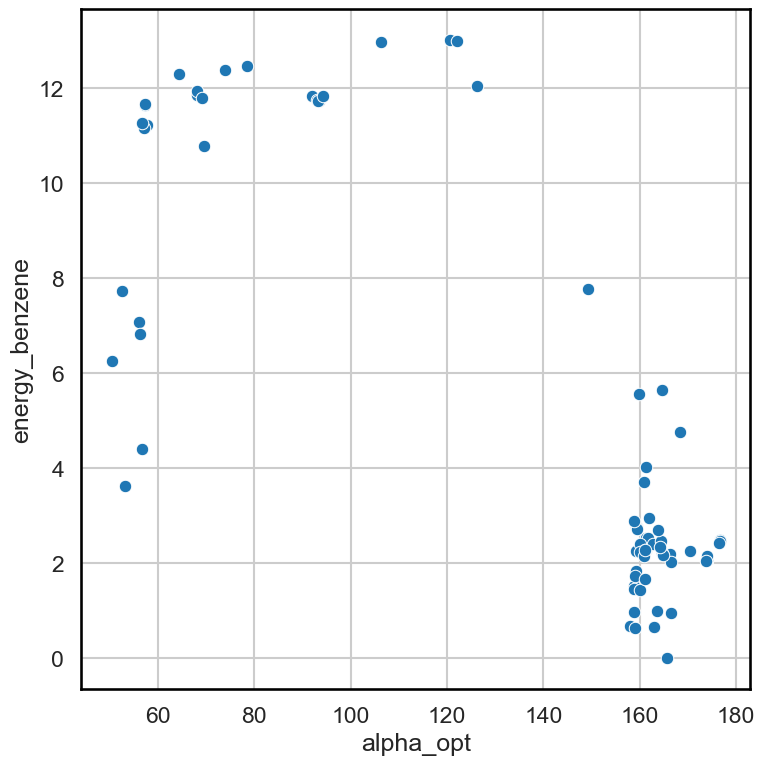

In [77]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=geometry, x='alpha_opt', y='rel_benzene')
# plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('alpha_opt')
plt.ylabel('energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

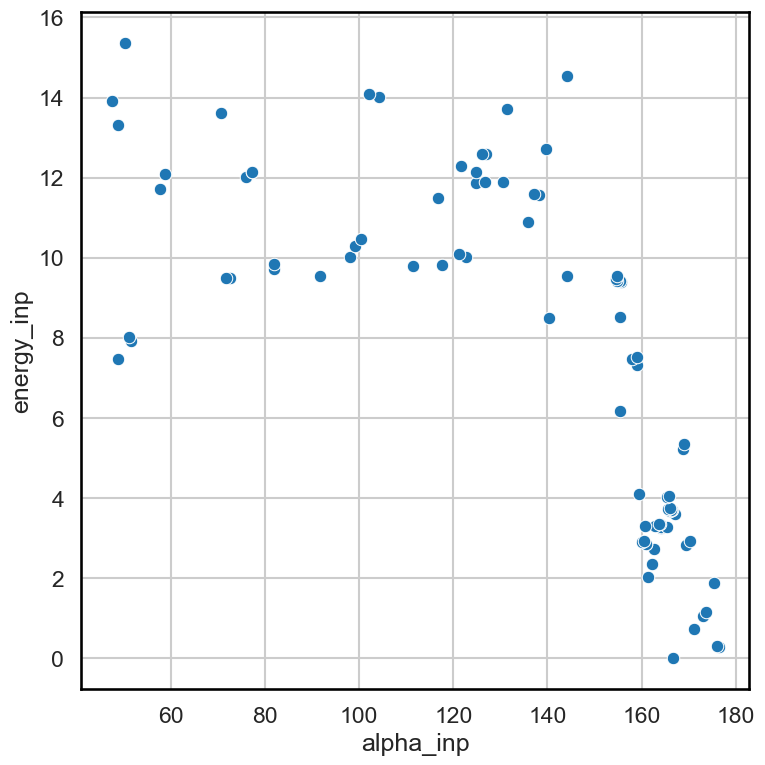

In [78]:
fig = plt.figure()
sns.scatterplot(data=geometry, x='alpha_inp', y='rel_energy_inp_kcal')
# plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('alpha_inp')
plt.ylabel('energy_inp')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

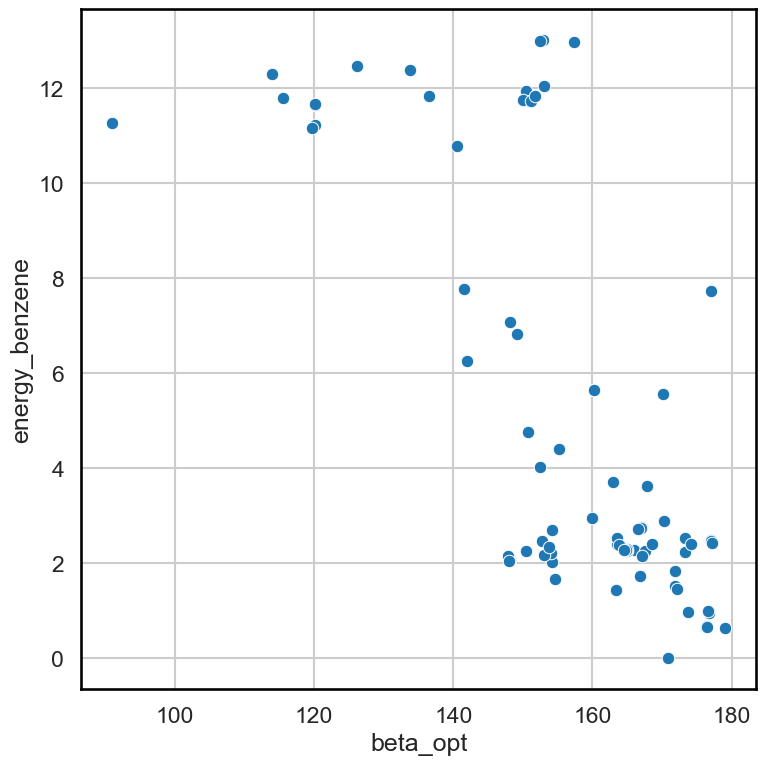

In [79]:
fig = plt.figure()
sns.scatterplot(data=geometry, x='beta_opt', y='rel_benzene')
# plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('beta_opt')
plt.ylabel('energy_benzene')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

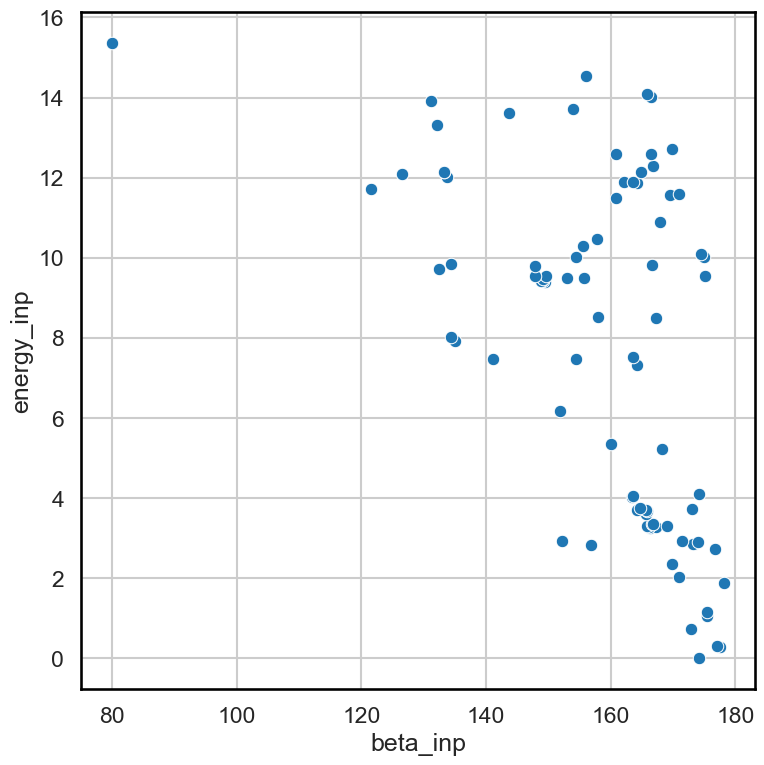

In [80]:
fig = plt.figure()
sns.scatterplot(data=geometry, x='beta_inp', y='rel_energy_inp_kcal')
# plt.xlim([-50, 50])
# plt.ylim([-13, 5])

plt.xlabel('beta_inp')
plt.ylabel('energy_inp')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

# Comparison of the opt and inp structures
Try to find the similarities in the energies for structures with similar alpha and beta values

In [82]:
geometry.head(5)

,name,alpha_inp,beta_inp,alpha_opt,beta_opt,rel_benzene,rel_energy_inp_kcal,cluster_inp,dA,dB,dE
0,structure_1,166.7,174.1,165.8,170.9,0.000000,0.000000,1,-0.9,-3.2,0.000000
1,structure_10,162.6,176.7,161.4,166.0,2.271583,2.718225,1,-1.2,-10.7,-0.446642
2,structure_11,169.4,156.8,166.4,154.0,2.186241,2.834853,1,-3.0,-2.8,-0.648612
3,structure_12,161.0,173.3,161.2,165.0,2.249620,2.847473,1,0.2,-8.3,-0.597853
4,structure_13,161.0,173.2,161.2,165.0,2.295428,2.860004,1,0.2,-8.2,-0.564576


In [106]:

corr_alpha = pd.DataFrame(columns=['name'], data=geometry['name'])
for i in range(geometry.shape[0]):
    
    corr_alpha[geometry.iloc[i,0]] = geometry.iloc[i,3] - geometry['alpha_inp']

    

In [107]:
corr_alpha

,name,structure_1,structure_10,structure_11,structure_12,structure_13,structure_14,structure_15,structure_16,structure_17,...,structure_83,structure_84,structure_85,structure_86,structure_87,structure_88,structure_89,structure_9,structure_90,structure_91
0,structure_1,-0.9,-5.3,-0.3,-5.5,-5.5,-5.6,-0.1,-5.6,-7.4,...,3.8,-113.5,-97.2,-5.6,-114.2,-72.5,-92.7,-5.6,-3.0,-110.0
1,structure_10,3.2,-1.2,3.8,-1.4,-1.4,-1.5,4.0,-1.5,-3.3,...,7.9,-109.4,-93.1,-1.5,-110.1,-68.4,-88.6,-1.5,1.1,-105.9
2,structure_11,-3.6,-8.0,-3.0,-8.2,-8.2,-8.3,-2.8,-8.3,-10.1,...,1.1,-116.2,-99.9,-8.3,-116.9,-75.2,-95.4,-8.3,-5.7,-112.7
3,structure_12,4.8,0.4,5.4,0.2,0.2,0.1,5.6,0.1,-1.7,...,9.5,-107.8,-91.5,0.1,-108.5,-66.8,-87.0,0.1,2.7,-104.3
4,structure_13,4.8,0.4,5.4,0.2,0.2,0.1,5.6,0.1,-1.7,...,9.5,-107.8,-91.5,0.1,-108.5,-66.8,-87.0,0.1,2.7,-104.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,structure_88,61.6,57.2,62.2,57.0,57.0,56.9,62.4,56.9,55.1,...,66.3,-51.0,-34.7,56.9,-51.7,-10.0,-30.2,56.9,59.5,-47.5
82,structure_89,63.7,59.3,64.3,59.1,59.1,59.0,64.5,59.0,57.2,...,68.4,-48.9,-32.6,59.0,-49.6,-7.9,-28.1,59.0,61.6,-45.4
83,structure_9,3.7,-0.7,4.3,-0.9,-0.9,-1.0,4.5,-1.0,-2.8,...,8.4,-108.9,-92.6,-1.0,-109.6,-67.9,-88.1,-1.0,1.6,-105.4
84,structure_90,21.7,17.3,22.3,17.1,17.1,17.0,22.5,17.0,15.2,...,26.4,-90.9,-74.6,17.0,-91.6,-49.9,-70.1,17.0,19.6,-87.4


# Removing duplicates from output by crest

The `ensemble.xyz` is generated, which is similar to the output from the xtb docking procedure.
It uses SPE (R2SCAN-3c) energy in vacuum for the energy sorting.
Look at opt_structures_to_crest.ipynb for the code

After successful crest run, the new sorted ensemble is renamed to crest_ensemble_orca.xyz and copied here.

In [80]:
df = pd.read_csv('crest_ensemble_orca.xyz')

In [81]:
# energy values

df_e = df[df.index % n_rows == 0].astype('float64')

In [82]:
final_df = inp_out.sort_values(by='SPE_vac').reset_index(drop=True)

In [83]:
df_e.columns = df_e.columns.str.strip()
df_e = df_e.rename(columns={'252':'SPE_vac'})
final_df = final_df.merge(df_e, on='SPE_vac')

In [84]:
final_df

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
0,structure_32,175.0,146.8,4.9,-4651.823922,2.046940,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,157.6,4.8,-311.154701,3.905622,3,0.000000,0.000000,1.359184,2.055719,3
1,structure_37,169.8,151.5,4.9,-4651.822600,2.049079,-4649.773521,-4651.844518,-4651.866693,-4651.876039,...,164.5,4.7,-311.153497,4.661281,3,2.171809,2.296055,3.713598,4.408251,3
2,structure_27,172.4,146.6,4.9,-4651.822523,2.046478,-4649.776045,-4651.844645,-4651.866843,-4651.876125,...,151.4,4.7,-311.156440,2.814623,3,0.587976,0.584211,1.987321,2.722134,3
3,structure_22,170.3,151.5,4.8,-4651.822233,2.046635,-4649.775598,-4651.844693,-4651.867332,-4651.876843,...,155.8,4.8,-311.156918,2.514542,3,0.868472,0.652609,1.778988,2.370101,3
4,structure_25,171.8,149.3,4.9,-4651.822095,2.046465,-4649.775630,-4651.844609,-4651.867260,-4651.876757,...,153.3,4.8,-311.156625,2.698414,3,0.848392,0.598644,1.717492,2.317391,3
5,structure_21,167.3,158.5,4.8,-4651.820789,2.046433,-4649.774356,-4651.843217,-4651.865854,-4651.875379,...,155.6,4.8,-311.157655,2.052086,3,1.647839,1.452056,2.579689,3.162018,3
6,structure_5,170.0,174.3,4.6,-4651.820501,2.046182,-4649.774319,-4651.844488,-4651.868841,-4651.879173,...,179.4,4.4,-311.160306,0.388930,1,1.671056,0.496987,0.547815,0.623744,1
7,structure_19,161.7,164.2,4.8,-4651.820484,2.047195,-4649.773289,-4651.843252,-4651.866056,-4651.875593,...,178.5,4.4,-311.157808,1.956353,1,2.317391,1.908255,2.931095,3.505893,1
8,structure_2,170.7,175.6,4.6,-4651.820032,2.046277,-4649.773755,-4651.843817,-4651.867925,-4651.878140,...,178.7,4.4,-311.160894,0.019810,1,2.024972,0.977659,1.182227,1.331574,1
9,structure_47,170.8,145.3,4.9,-4651.819799,2.049622,-4649.770177,-4651.842665,-4651.865883,-4651.875704,...,147.4,5.0,-311.153094,4.914312,3,4.270199,3.799567,4.562618,4.959204,3


The ensemble from crest had 47 structures, but here we see 48. It means that there were two structure with exactly the same SPE in the optimized dataset. We can locate and manualy delete this structure quite easily.

In [85]:
final_df['SPE_vac'].value_counts()

-4651.819243    2
-4651.823922    1
-4651.817545    1
-4651.816315    1
-4651.816169    1
-4651.815887    1
-4651.815773    1
-4651.815686    1
-4651.815609    1
-4651.815597    1
-4651.815412    1
-4651.815300    1
-4651.815249    1
-4651.814949    1
-4651.814808    1
-4651.814643    1
-4651.814551    1
-4651.814410    1
-4651.801196    1
-4651.797262    1
-4651.796848    1
-4651.796799    1
-4651.795875    1
-4651.817106    1
-4651.817643    1
-4651.822600    1
-4651.817815    1
-4651.822523    1
-4651.822233    1
-4651.822095    1
-4651.820789    1
-4651.820501    1
-4651.820484    1
-4651.820032    1
-4651.819799    1
-4651.819709    1
-4651.819596    1
-4651.819536    1
-4651.819493    1
-4651.819426    1
-4651.819402    1
-4651.818999    1
-4651.818753    1
-4651.818371    1
-4651.818206    1
-4651.817978    1
-4651.795708    1
Name: SPE_vac, dtype: int64

There are two structures with energy -4651.819243 eh. We can locate and delete one of them.

In [86]:
final_df[final_df['SPE_vac'] == -4651.819243]

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
16,structure_15,171.0,177.0,4.6,-4651.819243,2.045845,-4649.773398,-4651.842812,-4651.866741,-4651.876899,...,176.7,4.4,-311.159111,1.138565,1,2.248992,1.337222,1.654114,1.839229,1
17,structure_14,171.0,177.0,4.6,-4651.819243,2.045848,-4649.773395,-4651.842809,-4651.866735,-4651.876893,...,176.8,4.4,-311.159236,1.059888,1,2.250875,1.340987,1.659761,1.844876,1


Let's delete structure 15.

In [87]:
final_df = final_df[final_df['name'] != 'structure_15'].reset_index(drop=True)

In [88]:
final_df

,name,alpha_opt,beta_opt,distance_opt,SPE_vac,dG,energy_opt_vac,benzene,CH2Cl2,water,...,beta_inp,distance_inp,energy_inp,rel_energy_inp_kcal,cluster_inp,rel_vac,rel_benzene,rel_CH2Cl2,rel_water,cluster_opt
0,structure_32,175.0,146.8,4.9,-4651.823922,2.046940,-4649.776982,-4651.846038,-4651.868306,-4651.877649,...,157.6,4.8,-311.154701,3.905622,3,0.000000,0.000000,1.359184,2.055719,3
1,structure_37,169.8,151.5,4.9,-4651.822600,2.049079,-4649.773521,-4651.844518,-4651.866693,-4651.876039,...,164.5,4.7,-311.153497,4.661281,3,2.171809,2.296055,3.713598,4.408251,3
2,structure_27,172.4,146.6,4.9,-4651.822523,2.046478,-4649.776045,-4651.844645,-4651.866843,-4651.876125,...,151.4,4.7,-311.156440,2.814623,3,0.587976,0.584211,1.987321,2.722134,3
3,structure_22,170.3,151.5,4.8,-4651.822233,2.046635,-4649.775598,-4651.844693,-4651.867332,-4651.876843,...,155.8,4.8,-311.156918,2.514542,3,0.868472,0.652609,1.778988,2.370101,3
4,structure_25,171.8,149.3,4.9,-4651.822095,2.046465,-4649.775630,-4651.844609,-4651.867260,-4651.876757,...,153.3,4.8,-311.156625,2.698414,3,0.848392,0.598644,1.717492,2.317391,3
5,structure_21,167.3,158.5,4.8,-4651.820789,2.046433,-4649.774356,-4651.843217,-4651.865854,-4651.875379,...,155.6,4.8,-311.157655,2.052086,3,1.647839,1.452056,2.579689,3.162018,3
6,structure_5,170.0,174.3,4.6,-4651.820501,2.046182,-4649.774319,-4651.844488,-4651.868841,-4651.879173,...,179.4,4.4,-311.160306,0.388930,1,1.671056,0.496987,0.547815,0.623744,1
7,structure_19,161.7,164.2,4.8,-4651.820484,2.047195,-4649.773289,-4651.843252,-4651.866056,-4651.875593,...,178.5,4.4,-311.157808,1.956353,1,2.317391,1.908255,2.931095,3.505893,1
8,structure_2,170.7,175.6,4.6,-4651.820032,2.046277,-4649.773755,-4651.843817,-4651.867925,-4651.878140,...,178.7,4.4,-311.160894,0.019810,1,2.024972,0.977659,1.182227,1.331574,1
9,structure_47,170.8,145.3,4.9,-4651.819799,2.049622,-4649.770177,-4651.842665,-4651.865883,-4651.875704,...,147.4,5.0,-311.153094,4.914312,3,4.270199,3.799567,4.562618,4.959204,3


# Plot of the final data

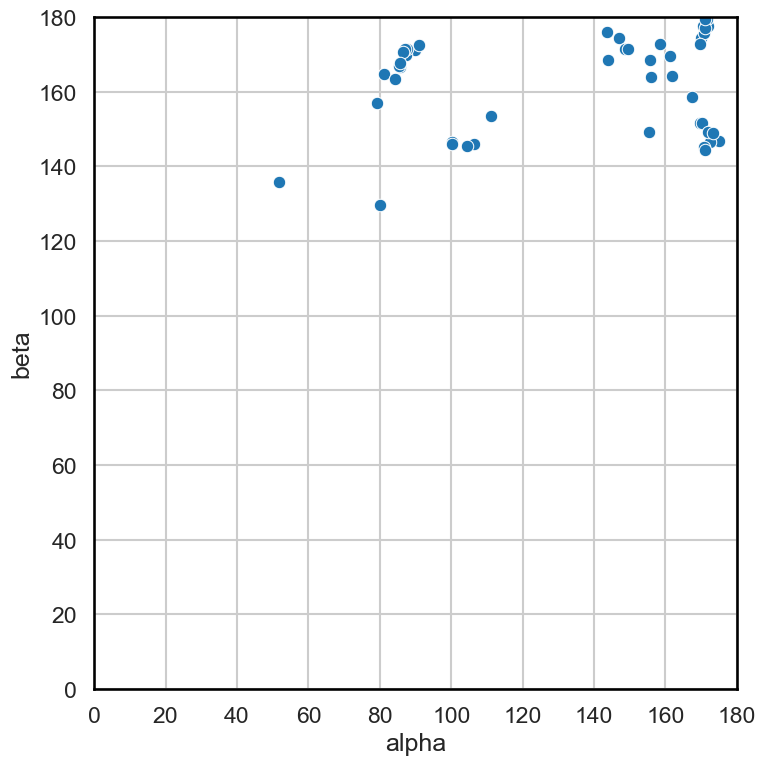

In [89]:
sns.set_context("talk")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
fig = plt.figure()
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

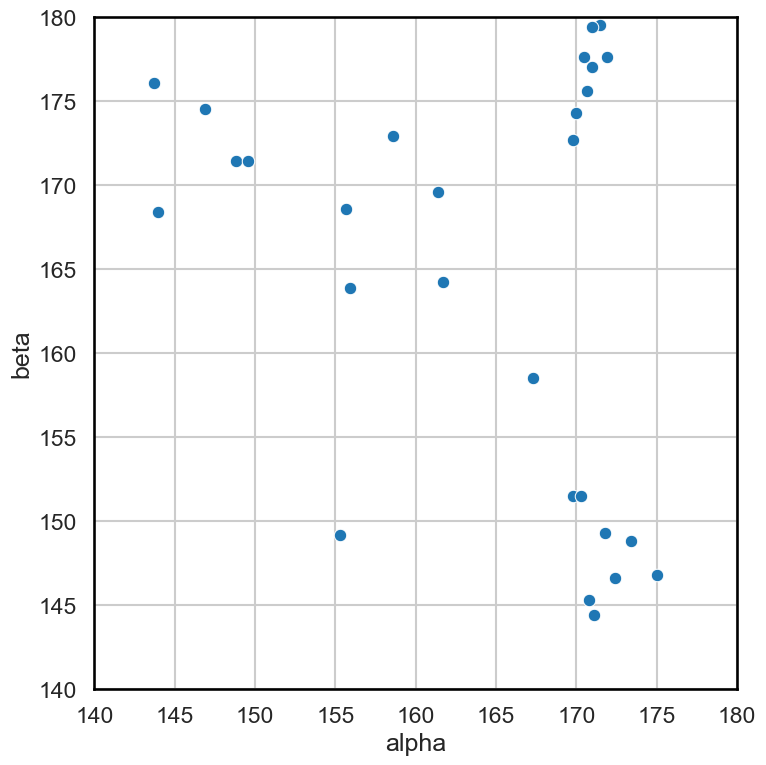

In [90]:

fig = plt.figure()
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

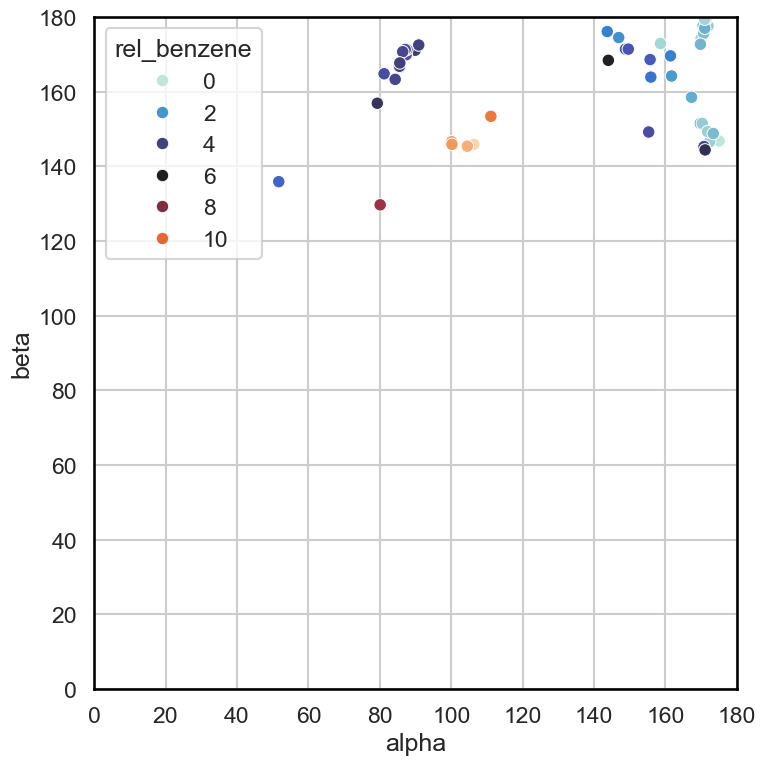

In [91]:
fig = plt.figure()
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire')

plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

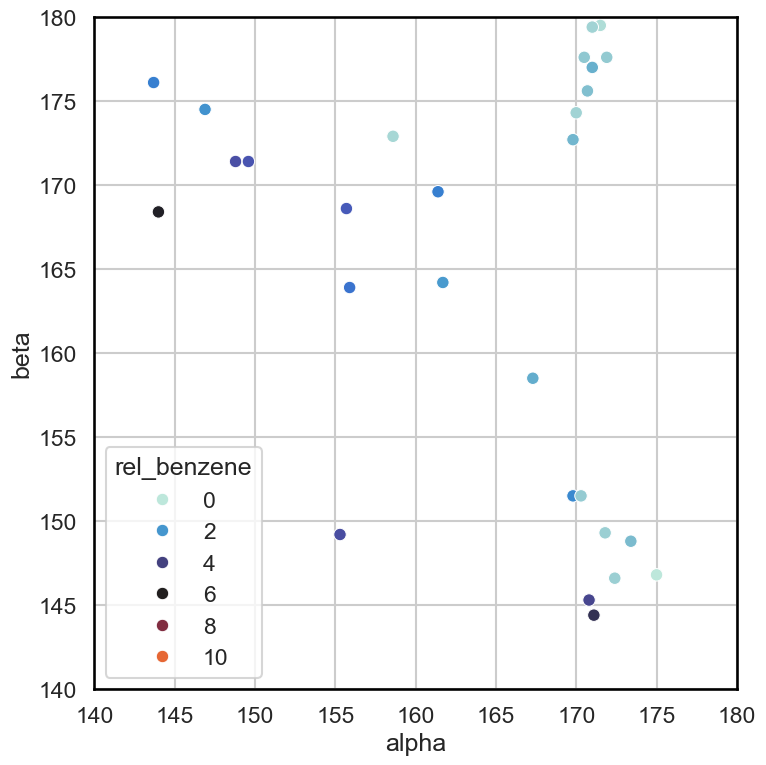

In [92]:
fig = plt.figure()
sns.scatterplot(data=final_df, x='alpha_opt', y='beta_opt', hue='rel_benzene', palette='icefire')

plt.xlim(140, 180)
plt.ylim(140, 180)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

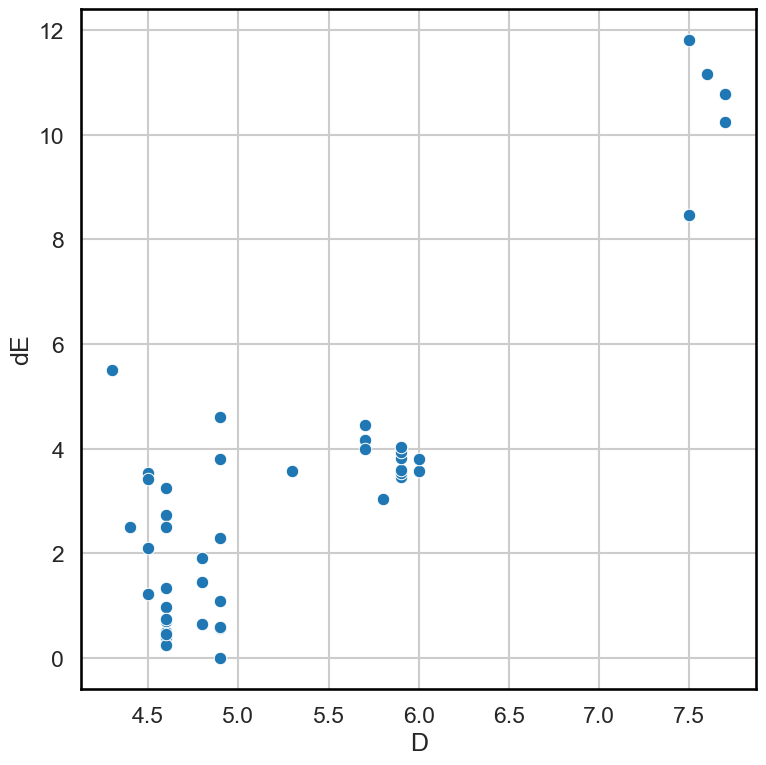

In [93]:
fig = plt.figure()
sns.scatterplot(data=final_df, x='distance_opt', y='rel_benzene')

# plt.xlim(140, 180)
# plt.ylim(140, 180)
plt.xlabel('D')
plt.ylabel('dE')
plt.gcf().set_size_inches(8, 8)
plt.tight_layout()
plt.show()

In [94]:
loc_s = 127
loc_cs = 182
loc_n = 1
loc_cn = 61

In [95]:
def geometry_from_xyz_2(folder):
    pattern_xyz = 'struc_[0-9]+_r2scan_opt\.xyz'
    file_name = [i for i in os.listdir(f'{folder}/') if re.findall(pattern_xyz, i)][0] # get the name of correct xyz
    with open(f'{folder}/{file_name}', 'r', encoding='utf-8') as xyz:
        lines = xyz.readlines()
        no_of_atoms = int(lines[0][:-1]) # get number of atoms
        
        # get the lines containing the atoms we need
        
        n_coord = np.array([float(i) for i in lines[loc_n+1].strip().split()[1:]])
        cn_coord = np.array([float(i) for i in lines[loc_cn+1].strip().split()[1:]])
        s_coord = np.array([float(i) for i in lines[loc_s+1].strip().split()[1:]])
        cs_coord = np.array([float(i) for i in lines[loc_cs+1].strip().split()[1:]])
        
        # calculate the corresponding angles
        # alpha
        
        vector_n_cn = cn_coord - n_coord
        vector_n_cs = cs_coord - n_coord
        len_n_cn = np.sqrt(np.square(vector_n_cn).sum())
        len_n_cs = np.sqrt(np.square(vector_n_cs).sum())
        
        cos_a = np.dot(vector_n_cn, vector_n_cs)/(len_n_cn*len_n_cs)
        alpha = np.around(np.degrees(np.arccos(cos_a)), decimals=1)
        
        # beta
        
        vector_s_cn = cn_coord - s_coord
        vector_s_cs = cs_coord - s_coord
        len_s_cn = np.sqrt(np.square(vector_s_cn).sum())
        len_s_cs = np.sqrt(np.square(vector_s_cs).sum())
        
        cos_b = np.dot(vector_s_cs, vector_s_cn)/(len_s_cs*len_s_cn)
        beta = np.around(np.degrees(np.arccos(cos_b)), decimals=1)
        
        # distance
        dist = np.around(np.sqrt(np.square(cn_coord - cs_coord).sum()), decimals=1)
               
        
        
    return alpha, beta, dist

In [96]:
outputs_2 = pd.DataFrame(columns=['name', 'alpha_opt', 'beta_opt', 'distance_CC', 'SPE_vac', 'dG'])
for folder in folders:
    alpha, beta, dist = geometry_from_xyz_2(folder)
    spe = r2scan_spe_vacuum(folder)
    dG = hess_reader(folder)
    
    outputs_2.loc[len(outputs_2.index)] = [folder, alpha, beta, dist, spe, dG]
    

In [97]:
outputs_2

,name,alpha_opt,beta_opt,distance_CC,SPE_vac,dG
0,structure_1,168.7,171.9,23.5,-4651.819516,2.046003
1,structure_10,168.7,172.0,23.5,-4651.819510,2.045981
2,structure_11,171.1,174.4,23.5,-4651.819536,2.045704
3,structure_12,170.6,174.7,23.5,-4651.819471,2.044866
4,structure_13,170.7,175.0,23.5,-4651.819493,2.045063
...,...,...,...,...,...,...
88,structure_9,168.7,171.9,23.5,-4651.819517,2.045993
89,structure_90,154.2,173.2,22.8,-4651.815773,2.045991
90,structure_91,169.1,171.8,23.5,-4651.819200,2.046323
91,structure_92,89.8,133.3,18.3,-4651.815597,2.045806


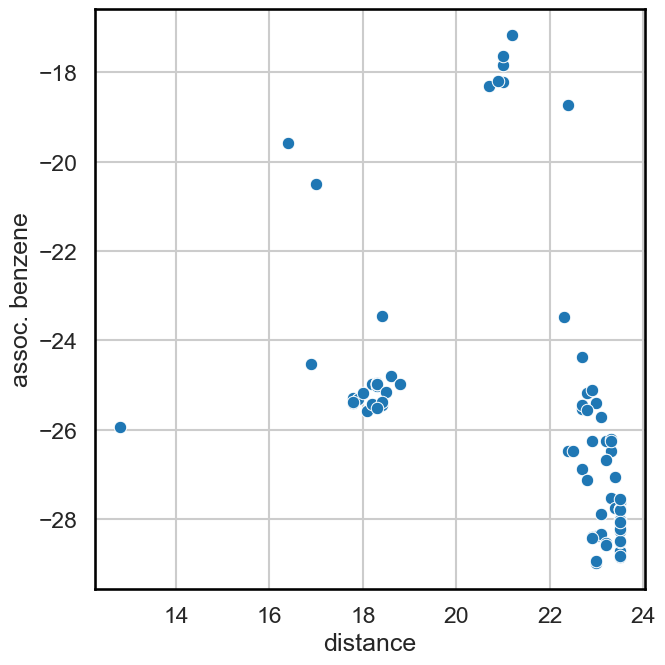

In [98]:
fig = plt.figure()
sns.scatterplot(x=outputs_2['distance_CC'], y=combined['association_benzene'])

# plt.xlim(140, 180)
# plt.ylim(140, 180)
plt.xlabel('distance')
plt.ylabel('assoc. benzene')
plt.gcf().set_size_inches(7, 7)
plt.tight_layout()
plt.show()